# Customer analysis in marketing campaigns

In this exercise, you work for a consulting firm as data scientist. In this scenario, your client is the marketing team of a grocery store. They would like to find which are the ideal customers according to the results of the last marketing campaigns. Your analysis will be helpful to adapt and modify products according to the different needs and behavior of their customers.

You dispose of a dataset from the mall dataset with several features:


People

- ID: Customer's unique identifier
- Year_Birth: Customer's birth year
- Education: Customer's education level
- Marital_Status: Customer's marital status
- Income: Customer's yearly household income
- Kidhome: Number of children in customer's household
- Teenhome: Number of teenagers in customer's household
- Dt_Customer: Date of customer's enrollment with the company
- Recency: Number of days since customer's last purchase
- Complain: 1 if customer complained in the last 2 years, 0 otherwise

Products

- MntWines: Amount spent on wine in last 2 years
- MntFruits: Amount spent on fruits in last 2 years
- MntMeatProducts: Amount spent on meat in last 2 years
- MntFishProducts: Amount spent on fish in last 2 years
- MntSweetProducts: Amount spent on sweets in last 2 years
- MntGoldProds: Amount spent on gold in last 2 years

Promotion

- NumDealsPurchases: Number of purchases made with a discount
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

Place

- NumWebPurchases: Number of purchases made through the company’s web site
- NumCatalogPurchases: Number of purchases made using a catalogue
- NumStorePurchases: Number of purchases made directly in stores
- NumWebVisitsMonth: Number of visits to company’s web site in the last month

'Z_CostContact' and 'Z_Revenue' contains constant value across all the observations and therefore they will not contribute anything in the analysis.

Use the recent know datetime in the dataset to estimate the age of customers

You have two days to do this study

## Import

In [1]:
# import des librairie

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from operator import attrgetter
import matplotlib.colors as mcolors
from datetime import timedelta
import plotly.express as px
import squarify
import missingno as mno
from datetime import date
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

In [2]:
campaign_df = pd.read_csv('marketing_campaign.csv', sep="\t")
campaign_df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [3]:
campaign_df.shape

(2240, 29)

In [4]:
campaign_df = campaign_df.drop("Z_CostContact", axis=1)

In [5]:
def missing_zero_values_table(df):
        '''Fonction pour regarder les valeurs manquantes'''
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        print(mno.matrix(df))
        return mz_table

In [6]:
def duplication(df):
    nb = df.duplicated().sum()
    dupli = df[df.duplicated()]
    return dupli

In [7]:
def boxplots(number):
    '''permet de ploter les differentes colonnes numerique en boxplot'''
    for col in number:
        sns.boxplot(x=number[col])
        plt.title(col)
        plt.show()

In [8]:
def univar_repartition(df, col):
    '''etude de la repartition des variables'''
    for i in col:
        fig = px.histogram(df, x=i)
        fig.update_layout(bargap=0.2)
        fig.show()

In [9]:
def outlier_identificator(df,colonne):
    '''Identification des outlier methode quantile'''
    q1=np.quantile(df[colonne],0.25)
    q3=np.quantile(df[colonne],0.75)
    out= (q3+1.5*(q3-q1)) 
    outlier=df.loc[df[colonne]> out]
    outlier = outlier.sort_values(by=colonne, ascending = False)
    return outlier

# EDA

## verification du type des colonnes 

In [10]:
campaign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [11]:
campaign_df[list(campaign_df.iloc[:, 20:].columns)] = campaign_df[list(campaign_df.iloc[:, 20:].columns)].astype("object")
campaign_df[["Kidhome","Teenhome"]] =  campaign_df[["Kidhome","Teenhome"]].astype("object")
campaign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   object 
 6   Teenhome             2240 non-null   object 
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [14]:
campaign_df['Dt_Customer'] = pd.to_datetime(campaign_df['Dt_Customer'] , format ="%d/%m/%Y")

In [15]:
campaign_df['Year']  = pd.DatetimeIndex(campaign_df['Dt_Customer'] ).year
campaign_df

ID  Year_Birth   Education Marital_Status   Income Kidhome Teenhome  \
0      5524        1957  Graduation         Single  58138.0       0        0   
1      2174        1954  Graduation         Single  46344.0       1        1   
2      4141        1965  Graduation       Together  71613.0       0        0   
3      6182        1984  Graduation       Together  26646.0       1        0   
4      5324        1981         PhD        Married  58293.0       1        0   
...     ...         ...         ...            ...      ...     ...      ...   
2235  10870        1967  Graduation        Married  61223.0       0        1   
2236   4001        1946         PhD       Together  64014.0       2        1   
2237   7270        1981  Graduation       Divorced  56981.0       0        0   
2238   8235        1956      Master       Together  69245.0       0        1   
2239   9405        1954         PhD        Married  52869.0       1        1   

     Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0     2012-04-09       58       635  ...                  7             0   
1     2014-08-03       38        11  ...                  5             0   
2     2013-08-21       26       426  ...                  4             0   
3     2014-10-02       26        11  ...                  6             0   
4     2014-01-19       94       173  ...                  5             0   
...          ...      ...       ...  ...                ...           ...   
2235  2013-06-13       46       709  ...                  5             0   
2236  2014-10-06       56       406  ...                  7             0   
2237  2014-01-25       91       908  ...                  6             0   
2238  2014-01-24        8       428  ...                  3             0   
2239  2012-10-15       40        84  ...                  7             0   

      AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0                0             0             0             0         0   
1                0             0             0             0         0   
2                0             0             0             0         0   
3                0             0             0             0         0   
4                0             0             0             0         0   
...            ...           ...           ...           ...       ...   
2235             0             0             0             0         0   
2236             0             0             1             0         0   
2237             1             0             0             0         0   
2238             0             0             0             0         0   
2239             0             0             0             0         0   

      Z_Revenue  Response  Year  
0            11         1  2012  
1            11         0  2014  
2            11         0  2013  
3            11         0  2014  
4            11         0  2014  
...         ...       ...   ...  
2235         11         0  2013  
2236         11         0  2014  
2237         11         0  2014  
2238         11         0  2014  
2239         11         1  2012  

[2240 rows x 29 columns]

In [16]:
campaign_df['Year'].value_counts()

2013    1189
2014     557
2012     494
Name: Year, dtype: int64

## Valeurs manquante ?

Your selected dataframe has 29 columns and 2240 Rows.
There are 1 columns that have missing values.
AxesSubplot(0.125,0.11;0.698618x0.77)


Zero Values  Missing Values  % of Total Values  \
Income            0              24                1.1   

        Total Zero Missing Values  % Total Zero Missing Values Data Type  
Income                         24                          1.1   float64

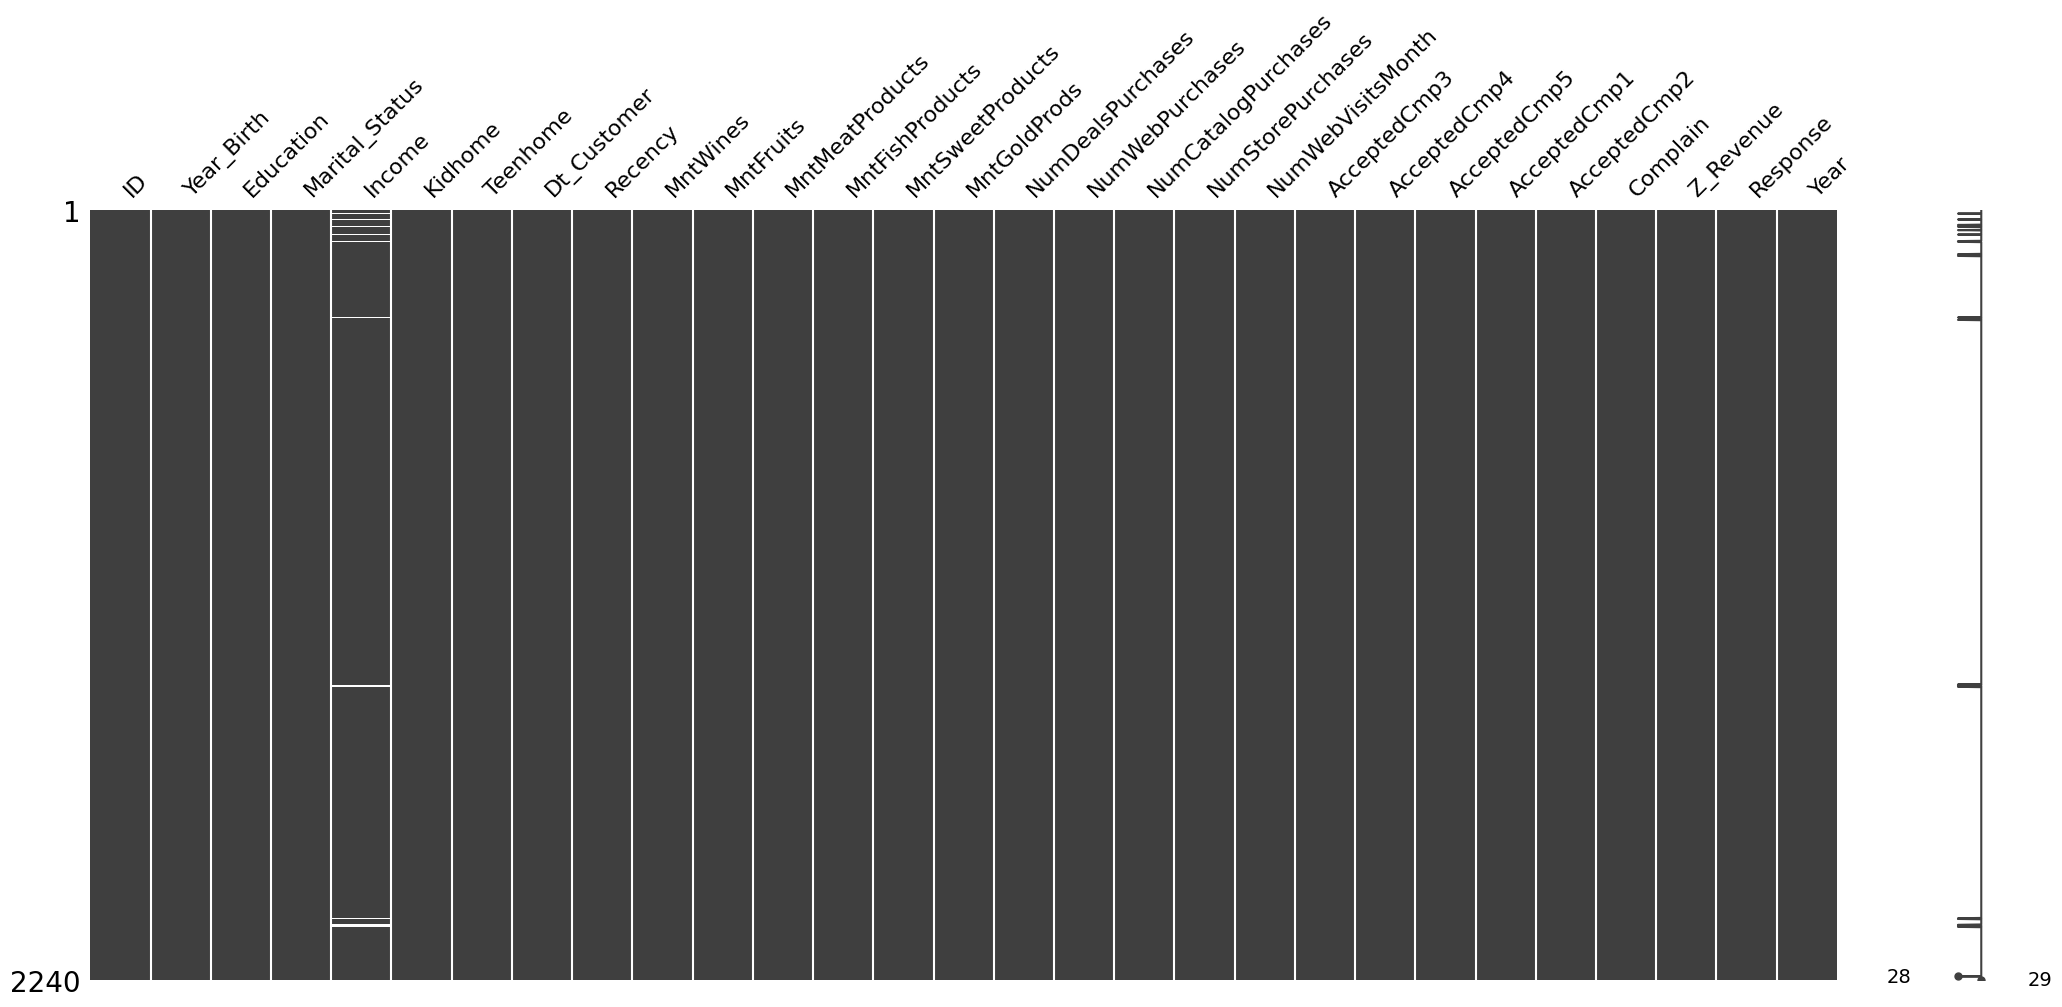

In [17]:
missing_zero_values_table(campaign_df)

## duplication ?

In [18]:
duplication(campaign_df)

Empty DataFrame
Columns: [ID, Year_Birth, Education, Marital_Status, Income, Kidhome, Teenhome, Dt_Customer, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Z_Revenue, Response, Year]
Index: []

[0 rows x 29 columns]

## Ajout d'une colonne Age

In [19]:
def calculateAge(birthDate):
    today = date.today()
    age = today.year - birthDate
 
    return age

In [20]:
campaign_df ['Age'] = (calculateAge(campaign_df ['Year_Birth']))
campaign_df 

ID  Year_Birth   Education Marital_Status   Income Kidhome Teenhome  \
0      5524        1957  Graduation         Single  58138.0       0        0   
1      2174        1954  Graduation         Single  46344.0       1        1   
2      4141        1965  Graduation       Together  71613.0       0        0   
3      6182        1984  Graduation       Together  26646.0       1        0   
4      5324        1981         PhD        Married  58293.0       1        0   
...     ...         ...         ...            ...      ...     ...      ...   
2235  10870        1967  Graduation        Married  61223.0       0        1   
2236   4001        1946         PhD       Together  64014.0       2        1   
2237   7270        1981  Graduation       Divorced  56981.0       0        0   
2238   8235        1956      Master       Together  69245.0       0        1   
2239   9405        1954         PhD        Married  52869.0       1        1   

     Dt_Customer  Recency  MntWines  ...  AcceptedCmp3  AcceptedCmp4  \
0     2012-04-09       58       635  ...             0             0   
1     2014-08-03       38        11  ...             0             0   
2     2013-08-21       26       426  ...             0             0   
3     2014-10-02       26        11  ...             0             0   
4     2014-01-19       94       173  ...             0             0   
...          ...      ...       ...  ...           ...           ...   
2235  2013-06-13       46       709  ...             0             0   
2236  2014-10-06       56       406  ...             0             0   
2237  2014-01-25       91       908  ...             0             1   
2238  2014-01-24        8       428  ...             0             0   
2239  2012-10-15       40        84  ...             0             0   

      AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Z_Revenue  Response  \
0                0             0             0         0         11         1   
1                0             0             0         0         11         0   
2                0             0             0         0         11         0   
3                0             0             0         0         11         0   
4                0             0             0         0         11         0   
...            ...           ...           ...       ...        ...       ...   
2235             0             0             0         0         11         0   
2236             0             1             0         0         11         0   
2237             0             0             0         0         11         0   
2238             0             0             0         0         11         0   
2239             0             0             0         0         11         1   

      Year  Age  
0     2012   66  
1     2014   69  
2     2013   58  
3     2014   39  
4     2014   42  
...    ...  ...  
2235  2013   56  
2236  2014   77  
2237  2014   42  
2238  2014   67  
2239  2012   69  

[2240 rows x 30 columns]

In [21]:
campaign_df = campaign_df.drop("Year_Birth",axis = 1)

In [22]:
campaign_df.columns

Index(['ID', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Z_Revenue', 'Response', 'Year', 'Age'],
      dtype='object')

In [23]:
number = campaign_df[['Age','Income', 'Kidhome',
       'Teenhome','Recency','MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']]

In [24]:
categ = campaign_df[[ 'Education', 'Marital_Status', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_Revenue', 'Response']]

In [25]:
for i in categ.columns :
    print("Pour",i,":")
    print("-----------")
    print(categ[i].value_counts())
    print("-----------")

Pour Education :
-----------
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64
-----------
Pour Marital_Status :
-----------
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64
-----------
Pour AcceptedCmp3 :
-----------
0    2077
1     163
Name: AcceptedCmp3, dtype: int64
-----------
Pour AcceptedCmp4 :
-----------
0    2073
1     167
Name: AcceptedCmp4, dtype: int64
-----------
Pour AcceptedCmp5 :
-----------
0    2077
1     163
Name: AcceptedCmp5, dtype: int64
-----------
Pour AcceptedCmp1 :
-----------
0    2096
1     144
Name: AcceptedCmp1, dtype: int64
-----------
Pour AcceptedCmp2 :
-----------
0    2210
1      30
Name: AcceptedCmp2, dtype: int64
-----------
Pour Complain :
-----------
0    2219
1      21
Name: Complain, dtype: int64
-----------
Pour Z_Revenue :
-----------
11    2240
Name: Z_Rev

##  Donnée abérante

In [26]:
campaign_df["Marital_Status"] = campaign_df.Marital_Status.replace(['Alone',"YOLO","Absurd"],'Single', regex=True)

In [27]:
number.describe()

Age         Income      Recency     MntWines    MntFruits  \
count  2240.000000    2216.000000  2240.000000  2240.000000  2240.000000   
mean     54.194196   52247.251354    49.109375   303.935714    26.302232   
std      11.984069   25173.076661    28.962453   336.597393    39.773434   
min      27.000000    1730.000000     0.000000     0.000000     0.000000   
25%      46.000000   35303.000000    24.000000    23.750000     1.000000   
50%      53.000000   51381.500000    49.000000   173.500000     8.000000   
75%      64.000000   68522.000000    74.000000   504.250000    33.000000   
max     130.000000  666666.000000    99.000000  1493.000000   199.000000   

       MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
count      2240.000000      2240.000000       2240.000000   2240.000000   
mean        166.950000        37.525446         27.062946     44.021875   
std         225.715373        54.628979         41.280498     52.167439   
min           0.000000         0.000000          0.000000      0.000000   
25%          16.000000         3.000000          1.000000      9.000000   
50%          67.000000        12.000000          8.000000     24.000000   
75%         232.000000        50.000000         33.000000     56.000000   
max        1725.000000       259.000000        263.000000    362.000000   

       NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
count        2240.000000      2240.000000          2240.000000   
mean            2.325000         4.084821             2.662054   
std             1.932238         2.778714             2.923101   
min             0.000000         0.000000             0.000000   
25%             1.000000         2.000000             0.000000   
50%             2.000000         4.000000             2.000000   
75%             3.000000         6.000000             4.000000   
max            15.000000        27.000000            28.000000   

       NumStorePurchases  NumWebVisitsMonth  
count        2240.000000        2240.000000  
mean            5.790179           5.316518  
std             3.250958           2.426645  
min             0.000000           0.000000  
25%             3.000000           3.000000  
50%             5.000000           6.000000  
75%             8.000000           7.000000  
max            13.000000          20.000000

## Outliers

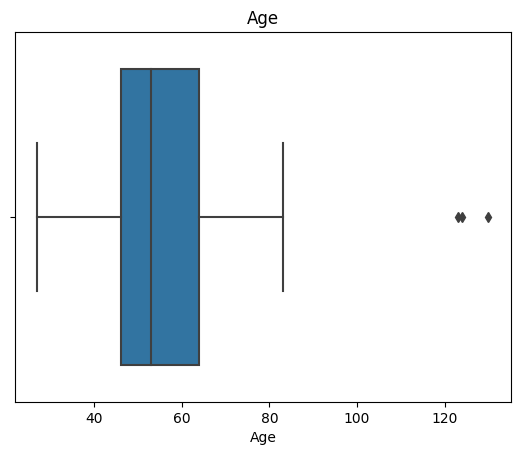

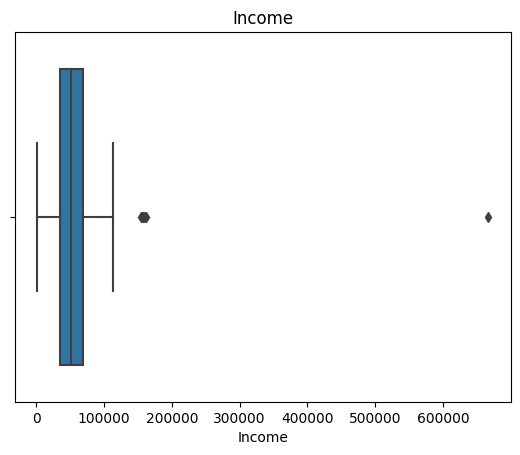

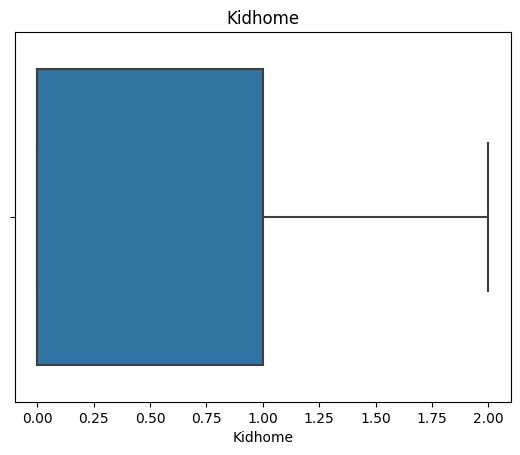

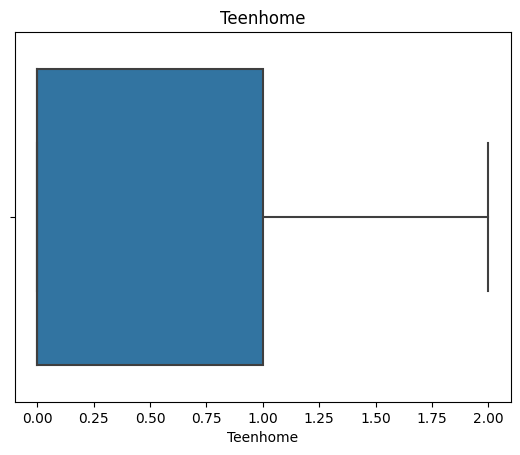

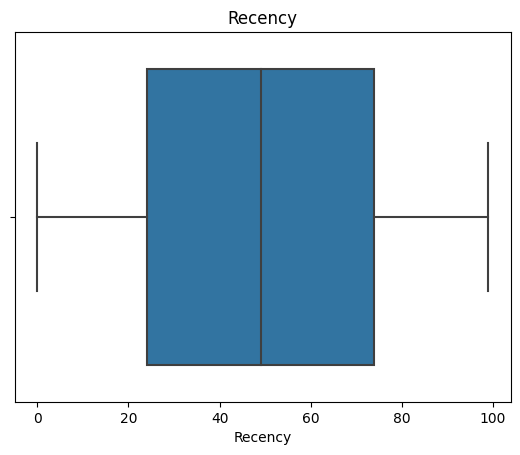

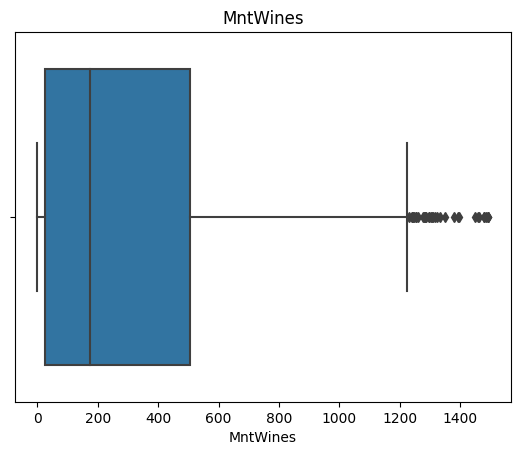

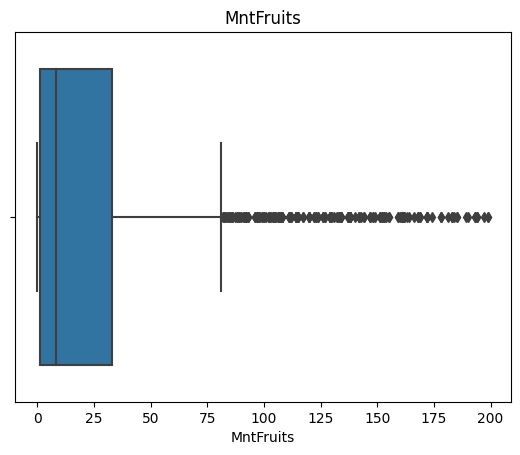

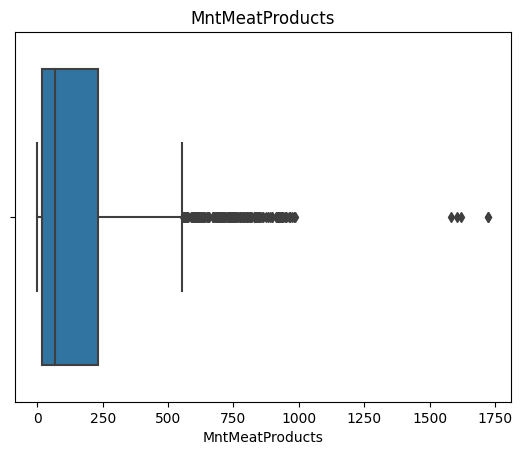

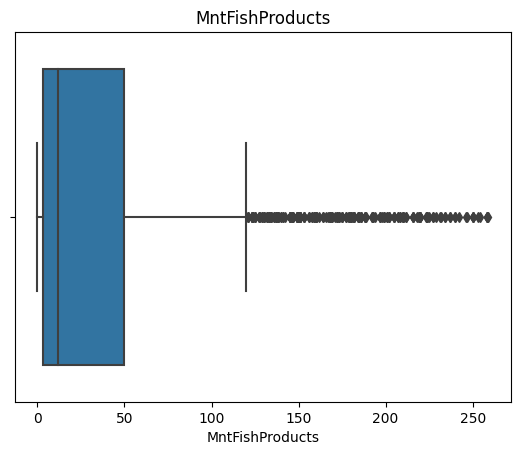

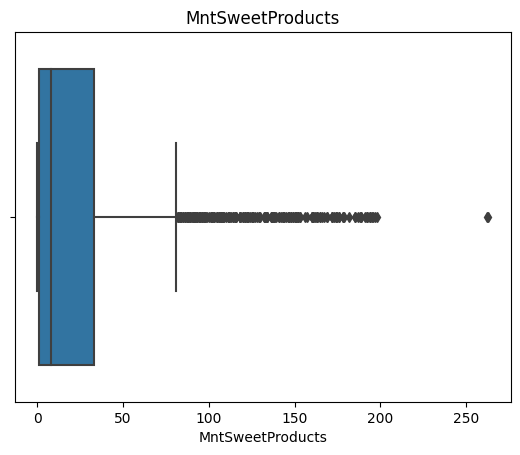

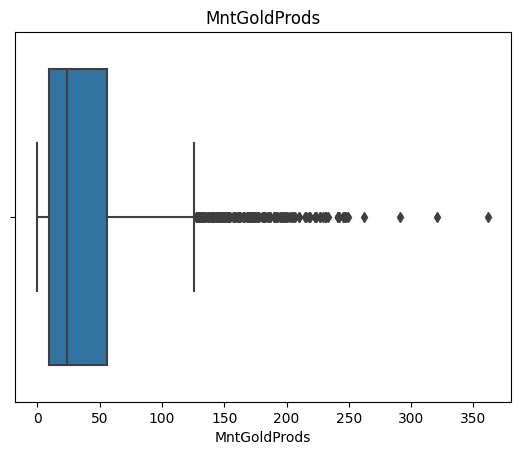

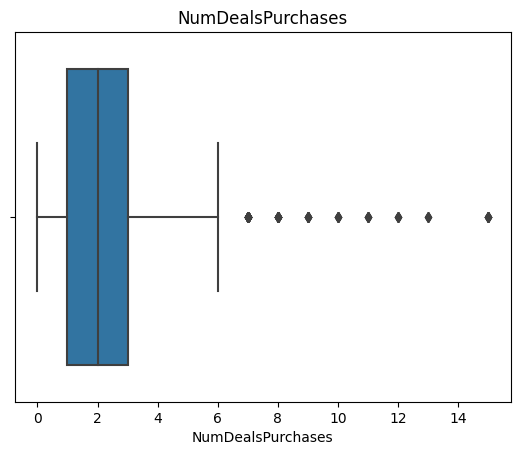

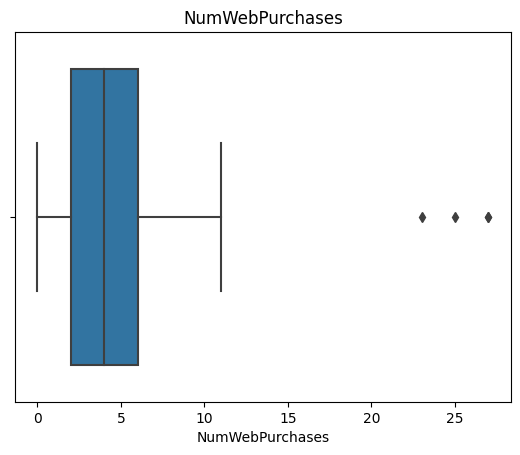

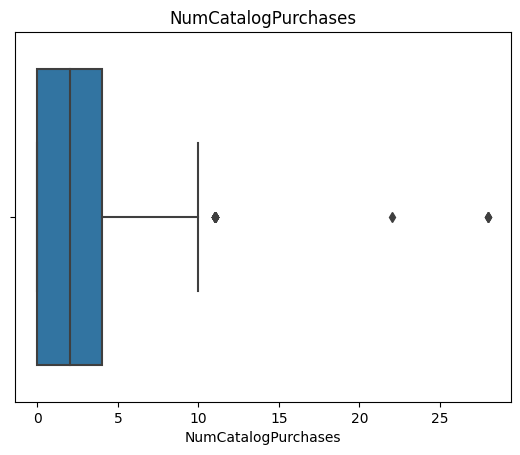

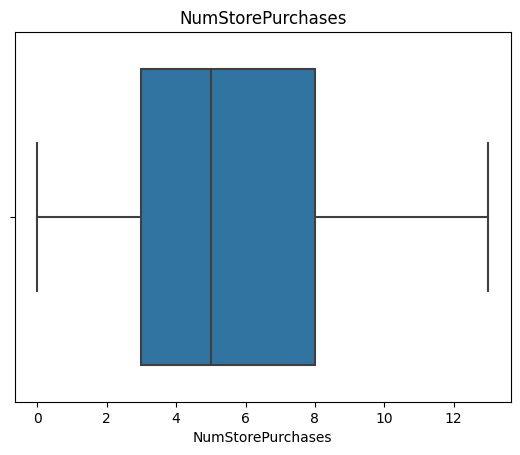

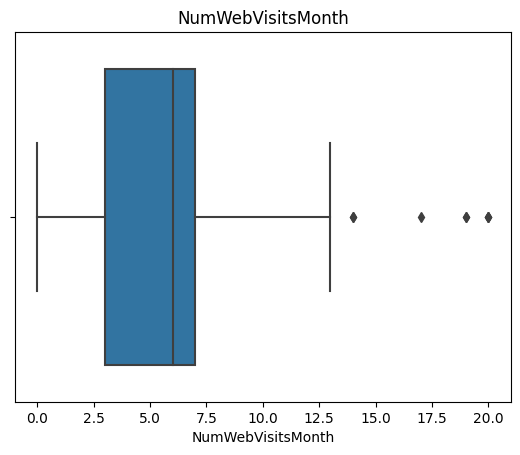

In [28]:
boxplots(number)

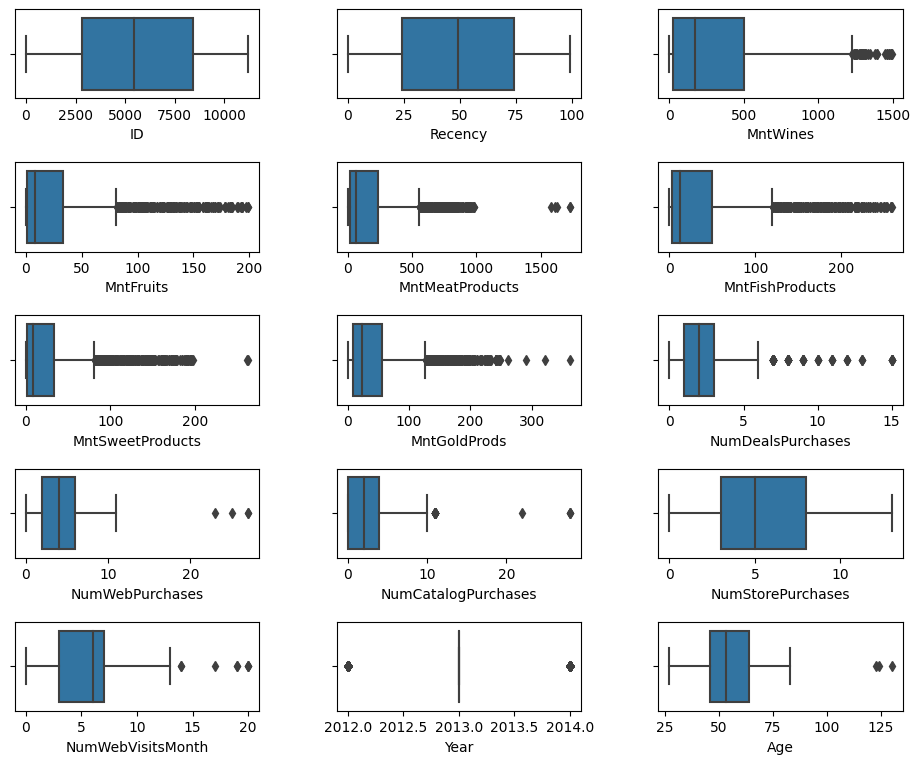

In [29]:
fig, axs = plt.subplots(5, 3, figsize=(10,8))
axs = axs.flatten()
fig.tight_layout(pad=2.5)
for i, col in enumerate(campaign_df.select_dtypes(include=['int']).columns):
    sns.boxplot(x=campaign_df.select_dtypes(include=['int'])[col], ax=axs[i])

In [30]:
outliers_age = outlier_identificator(campaign_df,'Age')
outliers_age

ID Education Marital_Status   Income Kidhome Teenhome Dt_Customer  \
239  11004  2n Cycle         Single  60182.0       0        1  2014-05-17   
339   1150       PhD       Together  83532.0       0        0  2013-09-26   
192   7829  2n Cycle       Divorced  36640.0       1        0  2013-09-26   

     Recency  MntWines  MntFruits  ...  AcceptedCmp3  AcceptedCmp4  \
239       23         8          0  ...             0             0   
339       36       755        144  ...             0             0   
192       99        15          6  ...             0             0   

     AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Z_Revenue  Response  \
239             0             0             0         0         11         0   
339             1             0             0         0         11         0   
192             0             0             0         1         11         0   

     Year  Age  
239  2014  130  
339  2013  124  
192  2013  123  

[3 rows x 29 columns]

In [31]:
campaign_df = campaign_df.drop([campaign_df.index[239], campaign_df.index[339], campaign_df.index[192]])

In [32]:
campaign_df['Age'].describe()

count    2237.000000
mean       54.098346
std        11.701917
min        27.000000
25%        46.000000
50%        53.000000
75%        64.000000
max        83.000000
Name: Age, dtype: float64

## Imputation valeur manquante Income

In [33]:
campaign_df[campaign_df['Income'].isnull()]

ID   Education Marital_Status  Income Kidhome Teenhome Dt_Customer  \
10     1994  Graduation        Married     NaN       1        0  2013-11-15   
27     5255  Graduation         Single     NaN       1        0  2013-02-20   
43     7281         PhD         Single     NaN       0        0  2013-05-11   
48     7244  Graduation         Single     NaN       2        1  2014-01-01   
58     8557  Graduation         Single     NaN       1        0  2013-06-17   
71    10629    2n Cycle        Married     NaN       1        0  2012-09-14   
90     8996         PhD        Married     NaN       2        1  2012-11-19   
91     9235  Graduation         Single     NaN       1        1  2014-05-27   
92     5798      Master       Together     NaN       0        0  2013-11-23   
128    8268         PhD        Married     NaN       0        1  2013-11-07   
133    1295  Graduation        Married     NaN       0        1  2013-11-08   
312    2437  Graduation        Married     NaN       0        0  2013-03-06   
319    2863  Graduation         Single     NaN       1        2  2013-08-23   
1379  10475      Master       Together     NaN       0        1  2013-01-04   
1382   2902  Graduation       Together     NaN       1        1  2012-03-09   
1383   4345    2n Cycle         Single     NaN       1        1  2014-12-01   
1386   3769         PhD       Together     NaN       1        0  2014-02-03   
2059   7187      Master       Together     NaN       1        1  2013-05-18   
2061   1612         PhD         Single     NaN       1        0  2013-05-31   
2078   5079  Graduation        Married     NaN       1        1  2013-03-03   
2079  10339      Master       Together     NaN       0        1  2013-06-23   
2081   3117  Graduation         Single     NaN       0        1  2013-10-18   
2084   5250      Master          Widow     NaN       0        0  2013-10-30   
2228   8720    2n Cycle       Together     NaN       0        0  2012-12-08   

      Recency  MntWines  MntFruits  ...  AcceptedCmp3  AcceptedCmp4  \
10         11         5          5  ...             0             0   
27         19         5          1  ...             0             0   
43         80        81         11  ...             0             0   
48         96        48          5  ...             0             0   
58         57        11          3  ...             0             0   
71         25        25          3  ...             0             0   
90          4       230         42  ...             0             0   
91         45         7          0  ...             0             0   
92         87       445         37  ...             0             0   
128        23       352          0  ...             0             0   
133        96       231         65  ...             0             0   
312        69       861        138  ...             0             1   
319        67       738         20  ...             0             1   
1379       39       187          5  ...             0             0   
1382       87        19          4  ...             0             0   
1383       49         5          1  ...             0             0   
1386       17        25          1  ...             0             0   
2059       52       375         42  ...             0             0   
2061       82        23          0  ...             0             0   
2078       82        71          1  ...             0             0   
2079       83       161          0  ...             0             0   
2081       95       264          0  ...             0             0   
2084       75       532        126  ...             0             0   
2228       53        32          2  ...             0             1   

      AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Z_Revenue  Response  \
10               0             0             0         0         11         0   
27               0             0             0         0         11         0   
43            

In [34]:
imputer = KNNImputer(n_neighbors = 5)
campaign_df['Income'] = imputer.fit_transform(campaign_df[['Income']])

In [35]:
campaign_df['Income'].describe()

count      2237.000000
mean      52236.581563
std       25043.111823
min        1730.000000
25%       35523.000000
50%       51717.000000
75%       68281.000000
max      666666.000000
Name: Income, dtype: float64

## Analyse Univarié 

In [36]:
univar_repartition(campaign_df, number)

In [37]:
univar_repartition(campaign_df, categ)

In [38]:
fig = px.histogram(campaign_df, x='Dt_Customer')
fig.update_layout(bargap=0.2)
fig.show()

## analyse multivarié

# Customer Segmentation

## rfm

In [39]:
campaign_df['MonetaryValue'] = campaign_df['MntWines'] + campaign_df['MntFruits'] + campaign_df['MntMeatProducts'] + campaign_df['MntFishProducts'] + campaign_df['MntFishProducts'] + campaign_df['MntSweetProducts'] + campaign_df['MntGoldProds']

In [40]:
campaign_df['Frequency'] =  campaign_df['NumWebPurchases'] + campaign_df['NumCatalogPurchases'] + campaign_df['NumStorePurchases']

In [41]:
rfm = campaign_df[['Recency', 'Frequency', 'MonetaryValue']]
rfm

Recency  Frequency  MonetaryValue
0          58         22           1789
1          38          4             29
2          26         20            887
3          26          6             63
4          94         14            468
...       ...        ...            ...
2235       46         16           1383
2236       56         15            444
2237       91         18           1273
2238        8         21            923
2239       40          8            174

[2237 rows x 3 columns]

In [42]:
rfm['r_percentile'] = rfm['Recency'].rank(pct=True,ascending=False)
rfm['r_score'] = pd.qcut(rfm['r_percentile'], 3, labels=range(3,0,-1))
rfm['f_percentile'] = rfm['Frequency'].rank(pct=True,ascending=True)
rfm['f_score'] = pd.qcut(rfm['f_percentile'], 3, labels=range(3,0,-1))
rfm['m_percentile'] = rfm['MonetaryValue'].rank(pct=True,ascending=True)
rfm['m_score'] = pd.qcut(rfm['m_percentile'], 3, labels=range(3,0,-1))
rfm

/tmp/ipykernel_2587/277676209.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2587/277676209.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2587/277676209.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2587/27

Recency  Frequency  MonetaryValue  r_percentile r_score  f_percentile  \
0          58         22           1789      0.404560       2      0.882879   
1          38          4             29      0.610192       2      0.108404   
2          26         20            887      0.731337       1      0.808672   
3          26          6             63      0.731337       1      0.276263   
4          94         14            468      0.051632       3      0.561913   
...       ...        ...            ...           ...     ...           ...   
2235       46         16           1383      0.540903       2      0.643496   
2236       56         15            444      0.426911       2      0.602816   
2237       91         18           1273      0.084265       3      0.728431   
2238        8         21            923      0.912383       1      0.846893   
2239       40          8            174      0.590523       2      0.387573   

     f_score  m_percentile m_score  
0          1      0.939875       1  
1          3      0.068619       3  
2          1      0.665177       2  
3          3      0.209879       3  
4          2      0.529057       2  
...      ...           ...     ...  
2235       2      0.836835       1  
2236       2      0.518328       2  
2237       1      0.807108       1  
2238       1      0.678140       1  
2239       2      0.377291       2  

[2237 rows x 9 columns]

In [43]:
rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)
rfm

/tmp/ipykernel_2587/651054242.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Recency  Frequency  MonetaryValue  r_percentile r_score  f_percentile  \
0          58         22           1789      0.404560       2      0.882879   
1          38          4             29      0.610192       2      0.108404   
2          26         20            887      0.731337       1      0.808672   
3          26          6             63      0.731337       1      0.276263   
4          94         14            468      0.051632       3      0.561913   
...       ...        ...            ...           ...     ...           ...   
2235       46         16           1383      0.540903       2      0.643496   
2236       56         15            444      0.426911       2      0.602816   
2237       91         18           1273      0.084265       3      0.728431   
2238        8         21            923      0.912383       1      0.846893   
2239       40          8            174      0.590523       2      0.387573   

     f_score  m_percentile m_score rfm_score  
0          1      0.939875       1       211  
1          3      0.068619       3       233  
2          1      0.665177       2       112  
3          3      0.209879       3       133  
4          2      0.529057       2       322  
...      ...           ...     ...       ...  
2235       2      0.836835       1       221  
2236       2      0.518328       2       222  
2237       1      0.807108       1       311  
2238       1      0.678140       1       111  
2239       2      0.377291       2       222  

[2237 rows x 10 columns]

/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flex

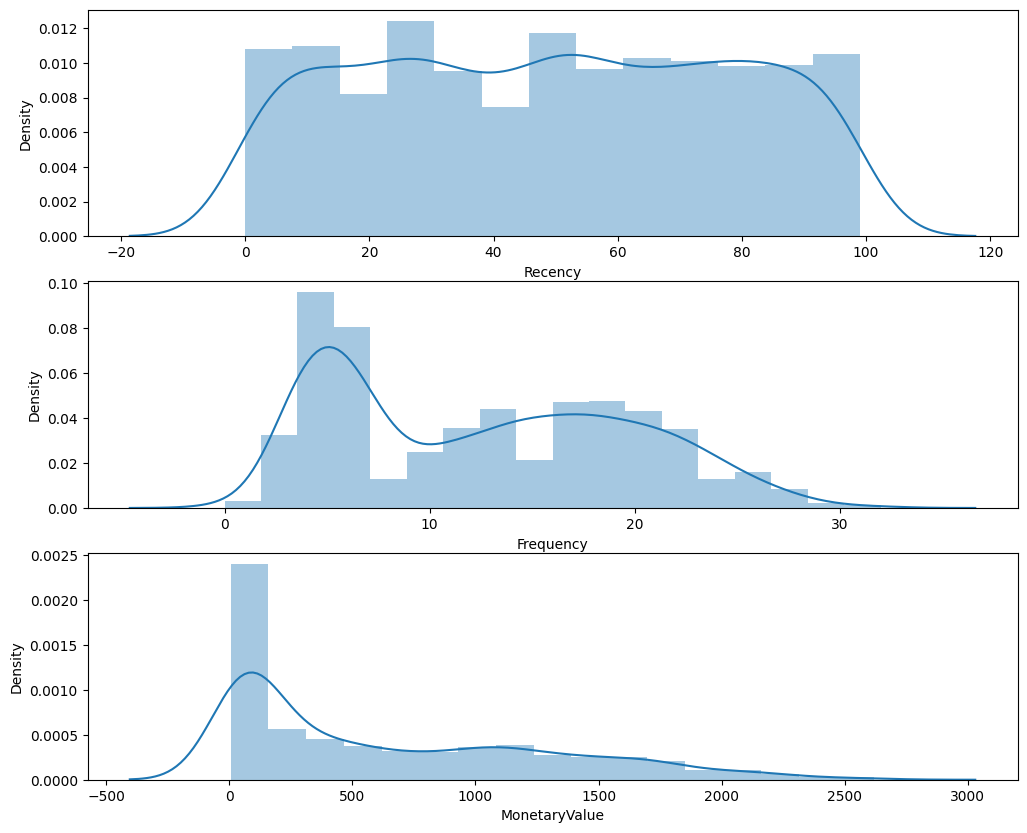

In [44]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfm['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(rfm['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfm['MonetaryValue'])
# Show the plot
plt.show()

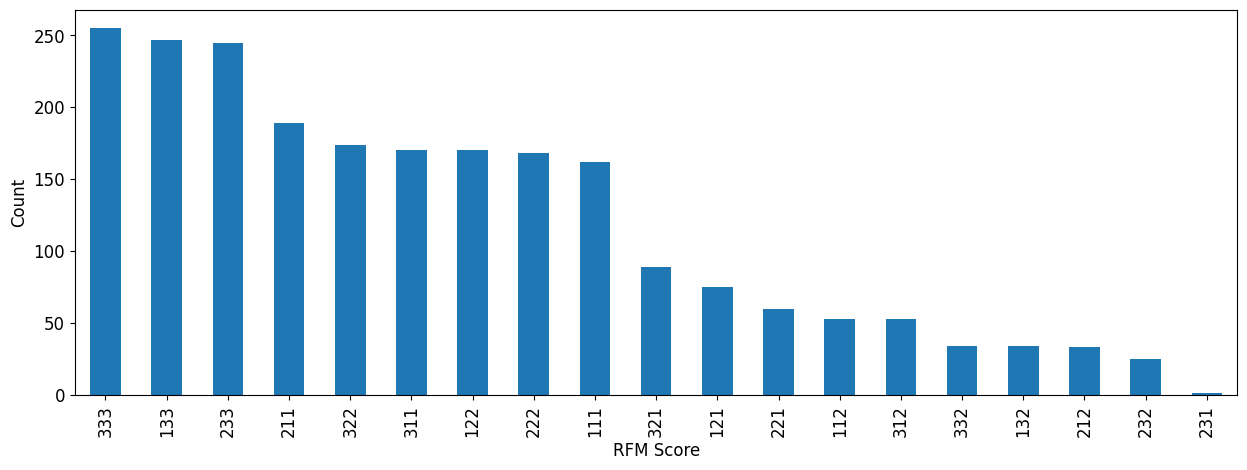

In [45]:
ax = rfm['rfm_score'].value_counts().plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

In [46]:
r_quarters = rfm['Recency'].quantile(q=[0.0, 0.25,0.5,0.75, 1]).to_list()
f_quarters = rfm['Frequency'].quantile(q=[0.0, 0.25,0.5,0.75, 1]).to_list()
m_quarters = rfm['MonetaryValue'].quantile(q=[0.0, 0.25,0.5,0.75, 1]).to_list()
quartile_spread = pd.DataFrame(list(zip(r_quarters, f_quarters, m_quarters)), 
                      columns=['Q_Recency','Q_Frequency', 'Q_Monetary'],
                     index = ['min', 'first_part','second_part','third_part', 'max'])
quartile_spread

Q_Recency  Q_Frequency  Q_Monetary
min                0.0          0.0         5.0
first_part        24.0          6.0        76.0
second_part       49.0         12.0       415.0
third_part        74.0         18.0      1104.0
max               99.0         32.0      2621.0

In [47]:
conditions  = [(rfm['rfm_score'] == "233") | (rfm['rfm_score'] == "333") | (rfm['rfm_score'] == "323") ,(rfm['rfm_score']== "122") | (rfm['rfm_score'] == "211") | (rfm['rfm_score'] == "111") | (rfm['rfm_score'] == "121") | (rfm['rfm_score'] == "131") | (rfm['rfm_score'] == "112") ,  (rfm['rfm_score'] == "311") | (rfm['rfm_score'] == "312") , (rfm['rfm_score'] == "332") | (rfm['rfm_score'] == "223") | (rfm['rfm_score'] == "232") | (rfm['rfm_score'] == "322") | (rfm['rfm_score'] == "123")]

choices = ['Champions', "Lost", "New Customers", "Potential"]

rfm["RFM_Level"] = np.select(conditions, choices, default = "Require activation")

rfm['RFM_Level'].value_counts()

# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   Recency Frequency MonetaryValue      
                      mean      mean          mean count
RFM_Level                                               
Champions             64.9       4.7          55.6   500
Lost                  25.2      18.6        1114.6   649
New Customers         82.9      21.4        1312.2   223
Potential             78.2      10.6         327.8   233
Require activation    38.5      10.0         504.4   632


/tmp/ipykernel_2587/1983292260.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



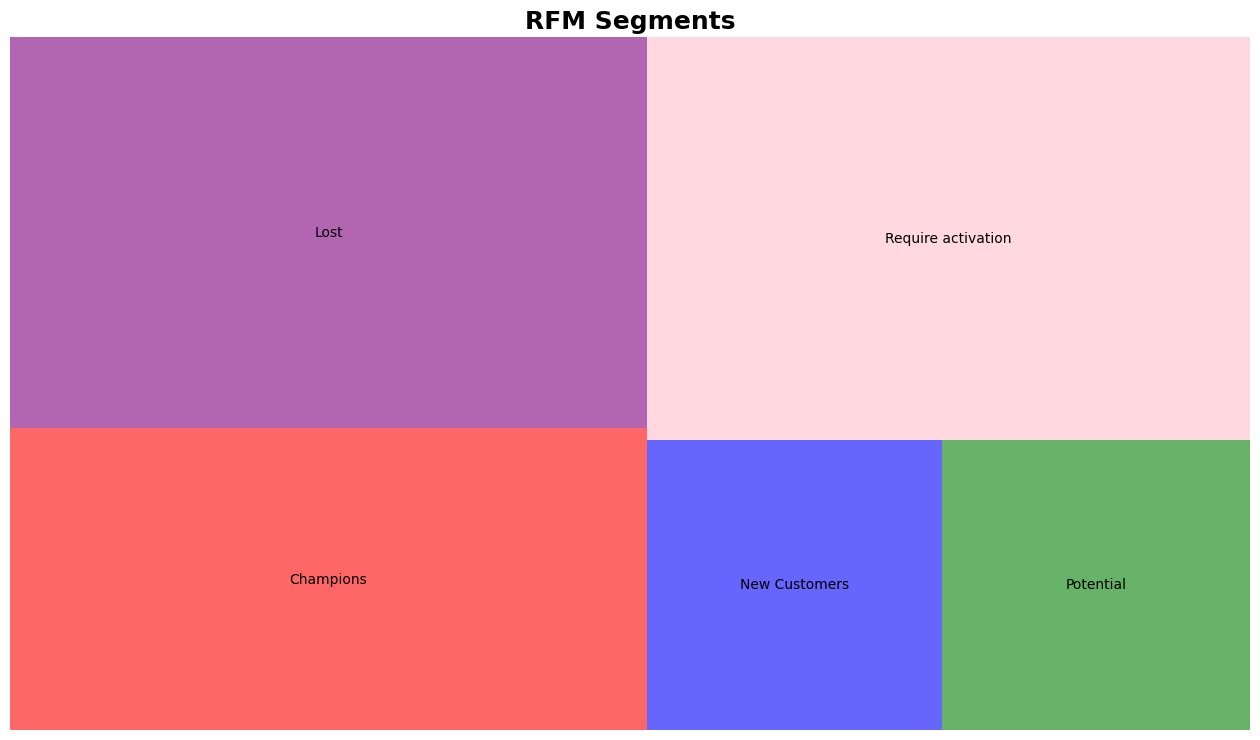

In [48]:
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
colors = ["red",  "purple", "blue", "green", 'pink']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Champions', "Lost", "New Customers", "Potential","Require activation"]
              , alpha=.6, color = colors )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

## Visualisation sur 

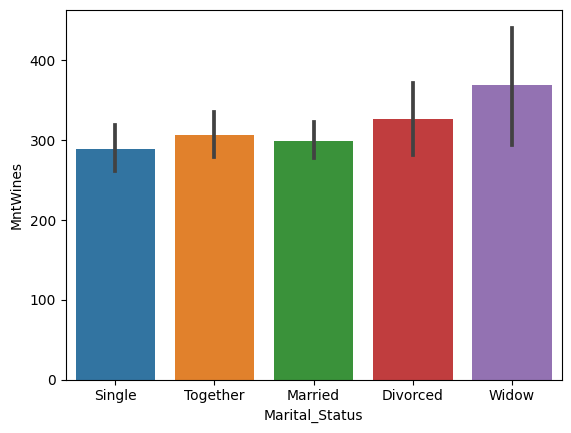

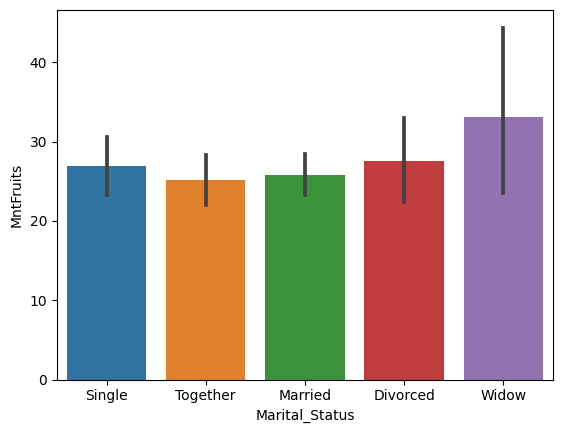

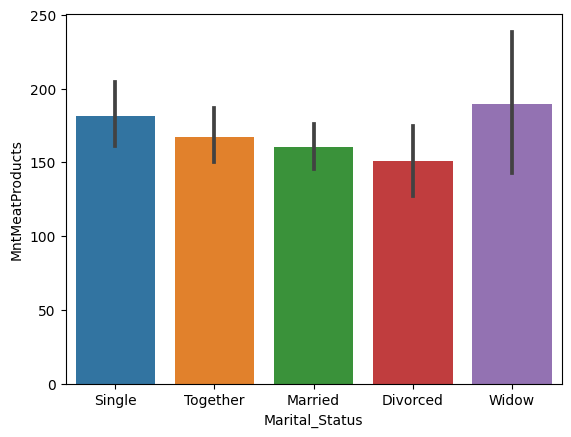

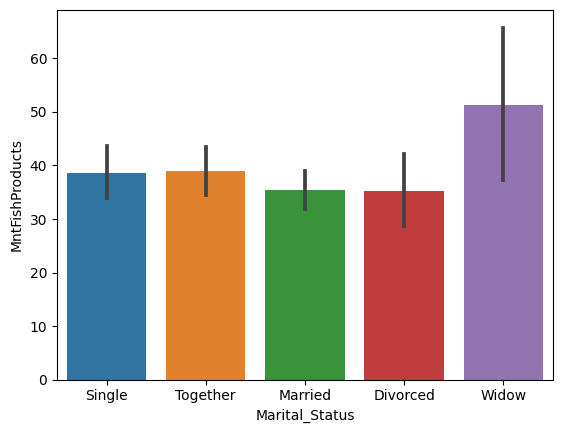

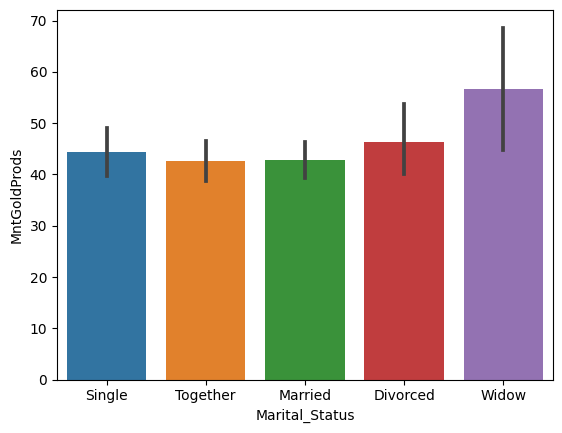

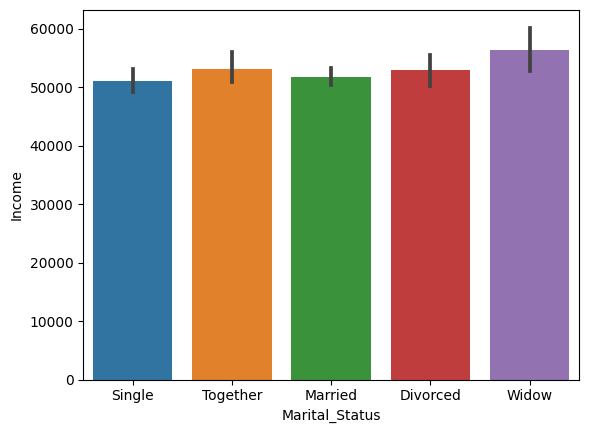

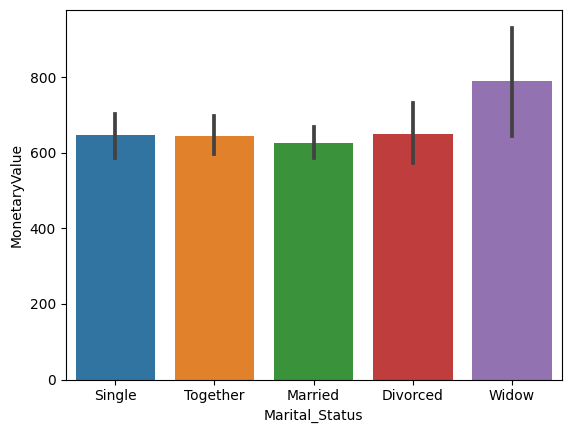

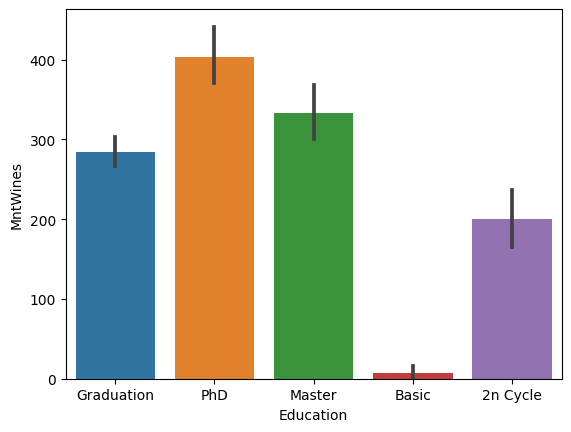

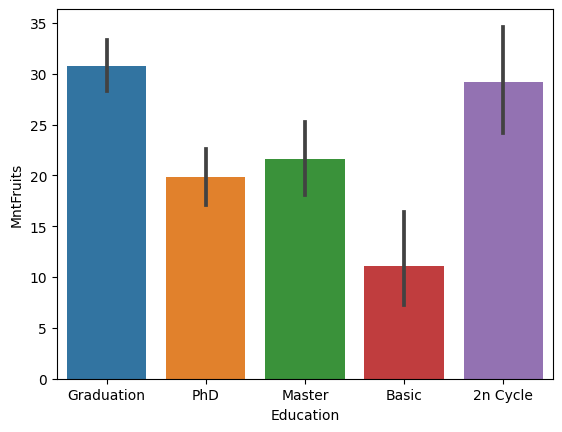

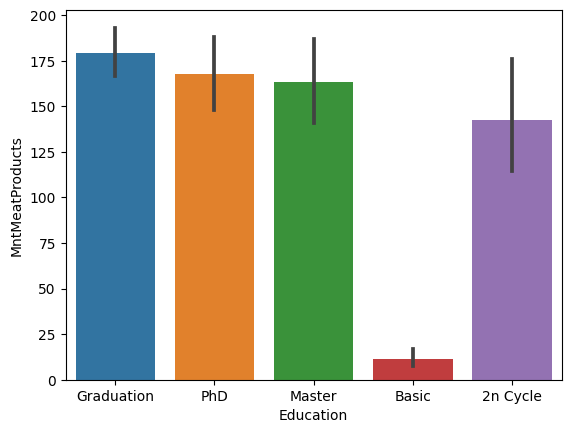

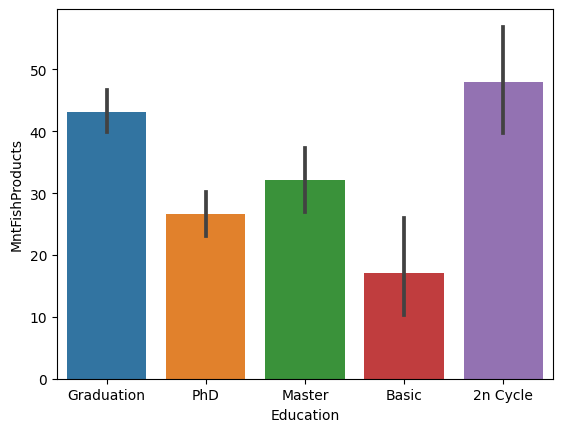

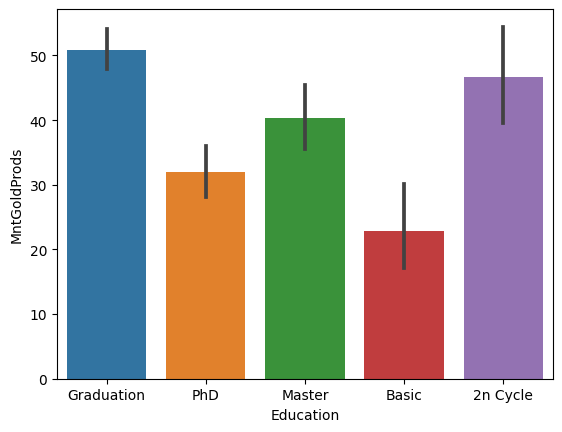

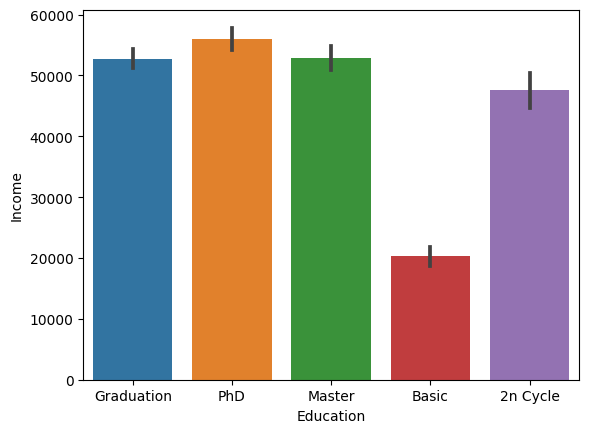

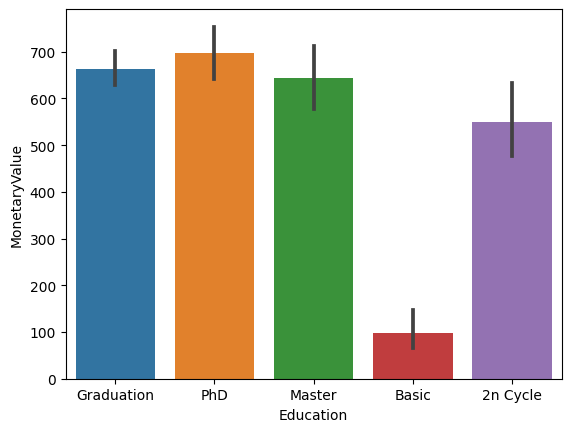

In [49]:
for w in ["Marital_Status","Education"]:
    for i in ["MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntGoldProds","Income","MonetaryValue"] :
        sns.barplot(data=campaign_df, x= w , y= i )
        plt.show()

## Clustering

In [50]:
rfm_cluster = rfm[['Recency','Frequency','MonetaryValue']]
rfm_cluster

Recency  Frequency  MonetaryValue
0          58         22           1789
1          38          4             29
2          26         20            887
3          26          6             63
4          94         14            468
...       ...        ...            ...
2235       46         16           1383
2236       56         15            444
2237       91         18           1273
2238        8         21            923
2239       40          8            174

[2237 rows x 3 columns]

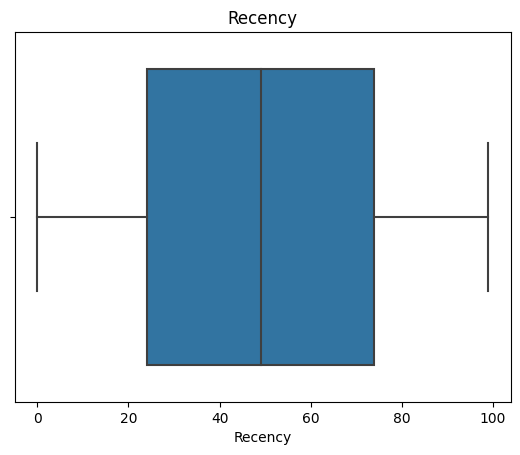

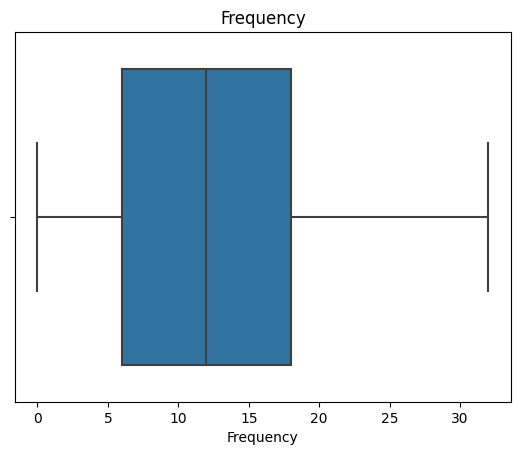

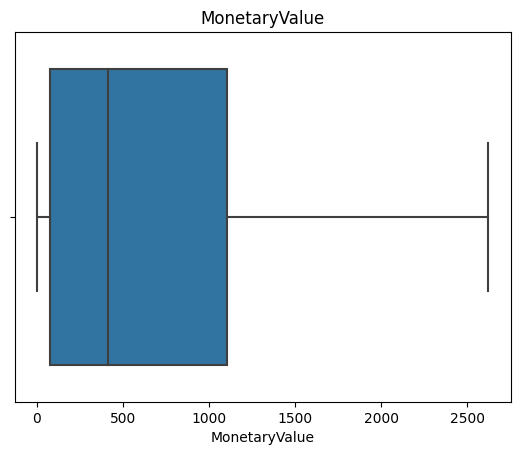

In [51]:
boxplots(rfm_cluster)

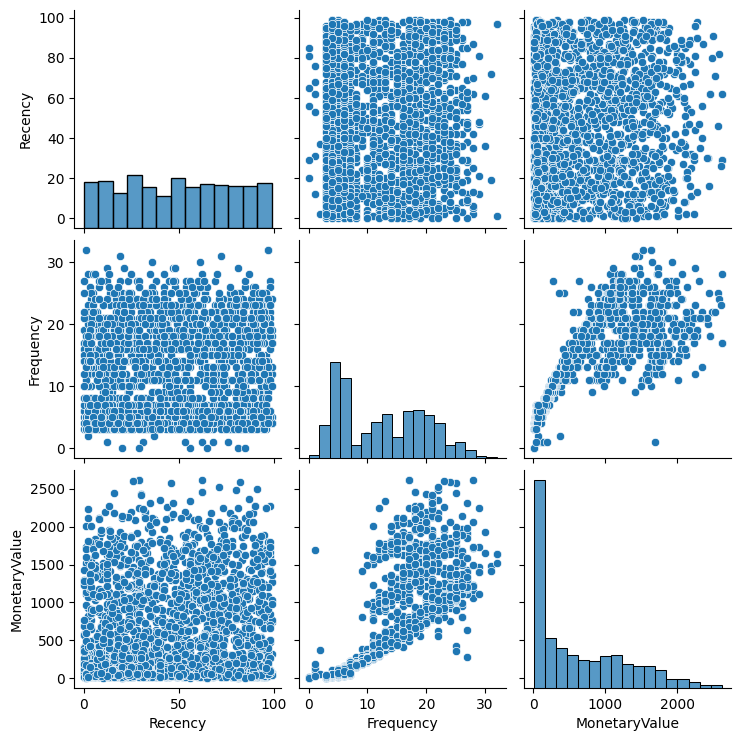

In [52]:
sns.pairplot(rfm_cluster)

In [53]:
from kneed import KneeLocator

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [54]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(rfm_cluster)
    sse.append(kmeans.inertia_)

/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

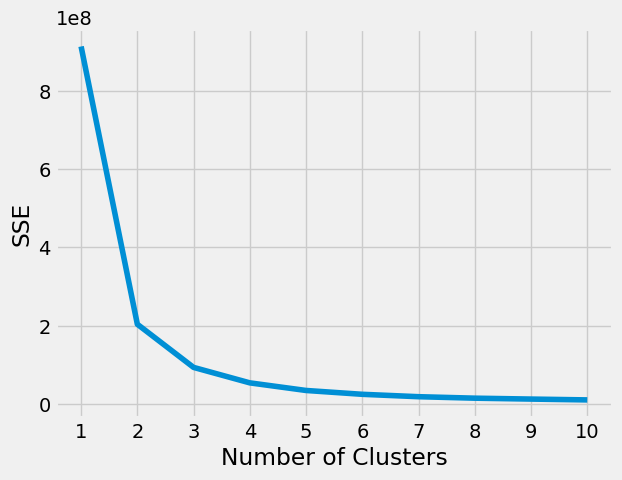

In [55]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [56]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

kl.elbow

3

In [57]:
 
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(rfm_cluster)
    score = silhouette_score(rfm_cluster, kmeans.labels_)
    silhouette_coefficients.append(score)

/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

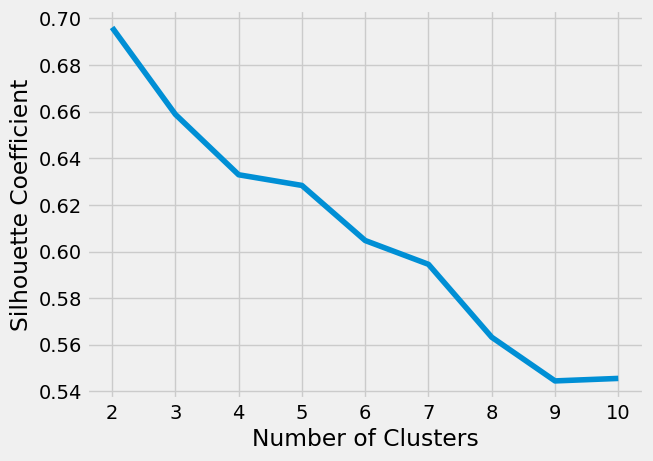

In [58]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/tmp/ipykernel_2587/1374948942.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



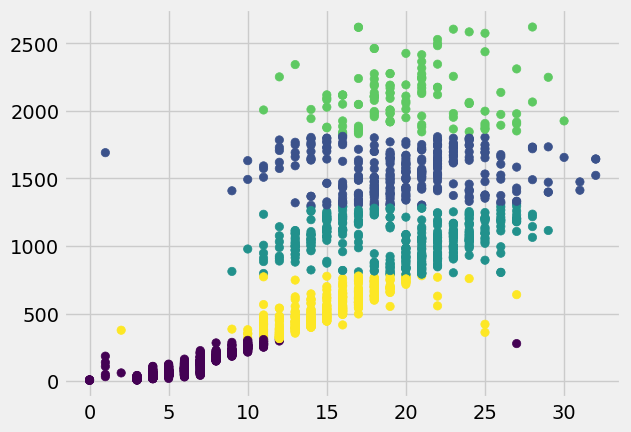

In [59]:
kmeans = KMeans(n_clusters = 5, max_iter = 1000)
labels = kmeans.fit_predict(rfm_cluster)
rfm_cluster['cluster'] = labels
plt.scatter(rfm_cluster.iloc[:, 1], rfm_cluster.iloc[:, 2], c = labels)

In [60]:
score = silhouette_score(rfm_cluster, kmeans.labels_)
score

0.6283690468690282

In [61]:
from mpl_toolkits.mplot3d import Axes3D

'''fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.array(rfm_cluster['Recency'])
y = np.array(rfm_cluster['Frequency'])
z = np.array(rfm_cluster['MonetaryValue'])

ax.scatter(x,y,z, c=rfm_cluster["cluster"], cmap="RdBu")

plt.show()'''


'fig = plt.figure()\nax = fig.add_subplot(111, projection=\'3d\')\nx = np.array(rfm_cluster[\'Recency\'])\ny = np.array(rfm_cluster[\'Frequency\'])\nz = np.array(rfm_cluster[\'MonetaryValue\'])\n\nax.scatter(x,y,z, c=rfm_cluster["cluster"], cmap="RdBu")\n\nplt.show()'

In [62]:
'''from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
colors = ['blue', 'red', 'green','purple','orange']

rfm_cluster2 = rfm_cluster.copy()
rfm_cluster2['c'] = rfm_cluster2.cluster.map({0:colors[0], 1:colors[1], 2:colors[2] ,3:colors[3], 4:colors[4]})
fig = plt.figure(figsize=(26,6))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(rfm_cluster2['Recency'], rfm_cluster2['Frequency'], rfm_cluster2['MonetaryValue'], c=rfm_cluster2.c, s=15)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('MonetaryValue')
plt.show()'''


"from mpl_toolkits.mplot3d import Axes3D\n%matplotlib widget\ncolors = ['blue', 'red', 'green','purple','orange']\n\nrfm_cluster2 = rfm_cluster.copy()\nrfm_cluster2['c'] = rfm_cluster2.cluster.map({0:colors[0], 1:colors[1], 2:colors[2] ,3:colors[3], 4:colors[4]})\nfig = plt.figure(figsize=(26,6))\nax = fig.add_subplot(131, projection='3d')\nax.scatter(rfm_cluster2['Recency'], rfm_cluster2['Frequency'], rfm_cluster2['MonetaryValue'], c=rfm_cluster2.c, s=15)\n\nax.set_xlabel('Recency')\nax.set_ylabel('Frequency')\nax.set_zlabel('MonetaryValue')\nplt.show()"

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


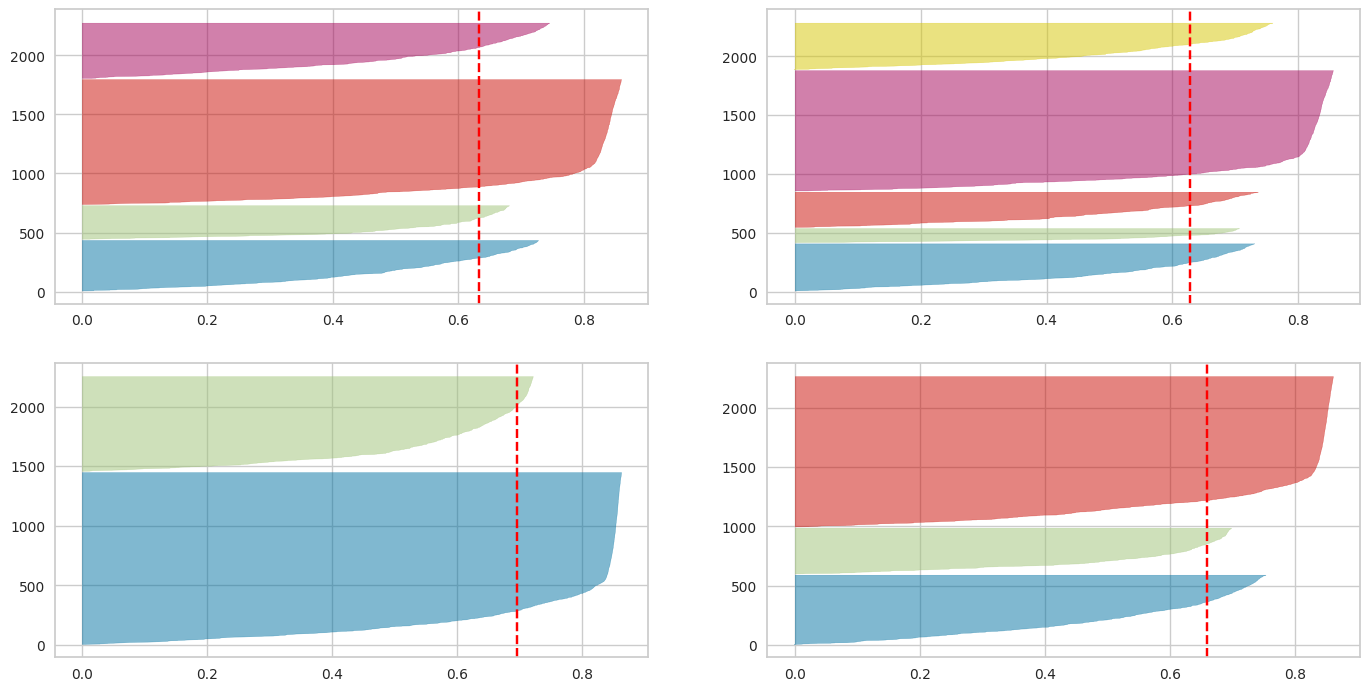

In [63]:
from yellowbrick.cluster import SilhouetteVisualizer
 
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-2][mod])
    visualizer.fit(rfm_cluster) 

Les coouteaux ne sont pas homogéne, du coup nous avons décidé d'ajouté plus de données

## Ajout de colonnes

In [64]:
rfm2= rfm[['Recency','Frequency','MonetaryValue']]

In [65]:
add = campaign_df[['ID','Age','Income', 'Kidhome','Teenhome','Year']]

In [66]:
clust= pd.concat([rfm2, add], axis = 1)
clust = clust.reset_index()
clust = clust.drop('index',axis= 1)
clust

Recency  Frequency  MonetaryValue     ID  Age   Income Kidhome Teenhome  \
0          58         22           1789   5524   66  58138.0       0        0   
1          38          4             29   2174   69  46344.0       1        1   
2          26         20            887   4141   58  71613.0       0        0   
3          26          6             63   6182   39  26646.0       1        0   
4          94         14            468   5324   42  58293.0       1        0   
...       ...        ...            ...    ...  ...      ...     ...      ...   
2232       46         16           1383  10870   56  61223.0       0        1   
2233       56         15            444   4001   77  64014.0       2        1   
2234       91         18           1273   7270   42  56981.0       0        0   
2235        8         21            923   8235   67  69245.0       0        1   
2236       40          8            174   9405   69  52869.0       1        1   

      Year  
0     2012  
1     2014  
2     2013  
3     2014  
4     2014  
...    ...  
2232  2013  
2233  2014  
2234  2014  
2235  2014  
2236  2012  

[2237 rows x 9 columns]

In [67]:
add_categ = campaign_df[[ 'Education', 'Marital_Status']]

In [68]:
# create and fit one hot encoder
encoder = OneHotEncoder()
features_1hot = encoder.fit_transform(add_categ)

# encode data and convert to dataframe
features_1hot_df = pd.DataFrame(features_1hot.toarray())

# set column names
features_1hot_df.set_axis(encoder.get_feature_names_out(['Education', 'Marital_Status']),
                          axis = 1, inplace = True)

# drop the original columns
df_enc = pd.concat([clust, features_1hot_df], axis = 1)

In [69]:
df_enc

Recency  Frequency  MonetaryValue     ID  Age   Income Kidhome Teenhome  \
0          58         22           1789   5524   66  58138.0       0        0   
1          38          4             29   2174   69  46344.0       1        1   
2          26         20            887   4141   58  71613.0       0        0   
3          26          6             63   6182   39  26646.0       1        0   
4          94         14            468   5324   42  58293.0       1        0   
...       ...        ...            ...    ...  ...      ...     ...      ...   
2232       46         16           1383  10870   56  61223.0       0        1   
2233       56         15            444   4001   77  64014.0       2        1   
2234       91         18           1273   7270   42  56981.0       0        0   
2235        8         21            923   8235   67  69245.0       0        1   
2236       40          8            174   9405   69  52869.0       1        1   

      Year  Education_2n Cycle  Education_Basic  Education_Graduation  \
0     2012                 0.0              0.0                   1.0   
1     2014                 0.0              0.0                   1.0   
2     2013                 0.0              0.0                   1.0   
3     2014                 0.0              0.0                   1.0   
4     2014                 0.0              0.0                   0.0   
...    ...                 ...              ...                   ...   
2232  2013                 0.0              0.0                   1.0   
2233  2014                 0.0              0.0                   0.0   
2234  2014                 0.0              0.0                   1.0   
2235  2014                 0.0              0.0                   0.0   
2236  2012                 0.0              0.0                   0.0   

      Education_Master  Education_PhD  Marital_Status_Divorced  \
0                  0.0            0.0                      0.0   
1                  0.0            0.0                      0.0   
2                  0.0            0.0                      0.0   
3                  0.0            0.0                      0.0   
4                  0.0            1.0                      0.0   
...                ...            ...                      ...   
2232               0.0            0.0                      0.0   
2233               0.0            1.0                      0.0   
2234               0.0            0.0                      1.0   
2235               1.0            0.0                      0.0   
2236               0.0            1.0                      0.0   

      Marital_Status_Married  Marital_Status_Single  Marital_Status_Together  \
0                        0.0                    1.0                      0.0   
1                        0.0                    1.0                      0.0   
2                        0.0                    0.0                      1.0   
3                        0.0                    0.0                      1.0   
4                        1.0                    0.0                      0.0   
...                      ...                    ...                      ...   
2232                     1.0                    0.0                      0.0   
2233                     0.0                    0.0                      1.0   
2234                     0.0                    0.0                      0.0   
2235                     0.0                    0.0                      1.0   
2236                     1.0                    0.0                      0.0   

      Marital_Status_Widow  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  
...                    ...  
2232                   0.0  
2233                   0.0  
2234                   0.0  
2235                   0.0  
2236                   0.0  

[2237 rows x 19 columns]

In [70]:
outlier_identificator(df_enc,'Income')

Recency  Frequency  MonetaryValue     ID  Age    Income Kidhome  \
2230       23          7             70   9432   46  666666.0       1   
614        31          1            109   1503   47  162397.0       1   
684        21         29           1734   1501   41  160803.0       0   
1297       37          2             61   5336   52  157733.0       1   
164        98         22           1609   8475   50  157243.0       0   
1650       13         28           1732   4931   46  157146.0       0   
2129       85          0              9  11181   74  156924.0       0   
652        81          0              7   5555   48  153924.0       0   

     Teenhome  Year  Education_2n Cycle  Education_Basic  \
2230        0  2013                 0.0              0.0   
614         1  2013                 0.0              0.0   
684         0  2012                 0.0              0.0   
1297        0  2013                 0.0              0.0   
164         1  2014                 0.0              0.0   
1650        0  2013                 0.0              0.0   
2129        0  2013                 0.0              0.0   
652         0  2014                 0.0              0.0   

      Education_Graduation  Education_Master  Education_PhD  \
2230                   1.0               0.0            0.0   
614                    0.0               0.0            1.0   
684                    0.0               0.0            1.0   
1297                   0.0               1.0            0.0   
164                    0.0               0.0            1.0   
1650                   1.0               0.0            0.0   
2129                   0.0               0.0            1.0   
652                    1.0               0.0            0.0   

      Marital_Status_Divorced  Marital_Status_Married  Marital_Status_Single  \
2230                      0.0                     0.0                    0.0   
614                       0.0                     0.0                    0.0   
684                       0.0                     1.0                    0.0   
1297                      0.0                     0.0                    0.0   
164                       0.0                     1.0                    0.0   
1650                      0.0                     0.0                    0.0   
2129                      0.0                     1.0                    0.0   
652                       1.0                     0.0                    0.0   

      Marital_Status_Together  Marital_Status_Widow  
2230                      1.0                   0.0  
614                       1.0                   0.0  
684                       0.0                   0.0  
1297                      1.0                   0.0  
164                       0.0                   0.0  
1650                      1.0                   0.0  
2129                      0.0                   0.0  
652                       0.0                   0.0

In [71]:
df_enc = df_enc.drop([df_enc.index[2230], df_enc.index[614], df_enc.index[684], df_enc.index[1297], df_enc.index[164], df_enc.index[1650], df_enc.index[2129], df_enc.index[652]])

In [72]:
df_enc['Income'].describe()

count      2229.000000
mean      51628.711062
std       20601.298933
min        1730.000000
25%       35416.000000
50%       51563.000000
75%       68118.000000
max      113734.000000
Name: Income, dtype: float64

In [73]:
# A list holds the SSE values for each k
sse2 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_enc)
    sse2.append(kmeans.inertia_)

/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


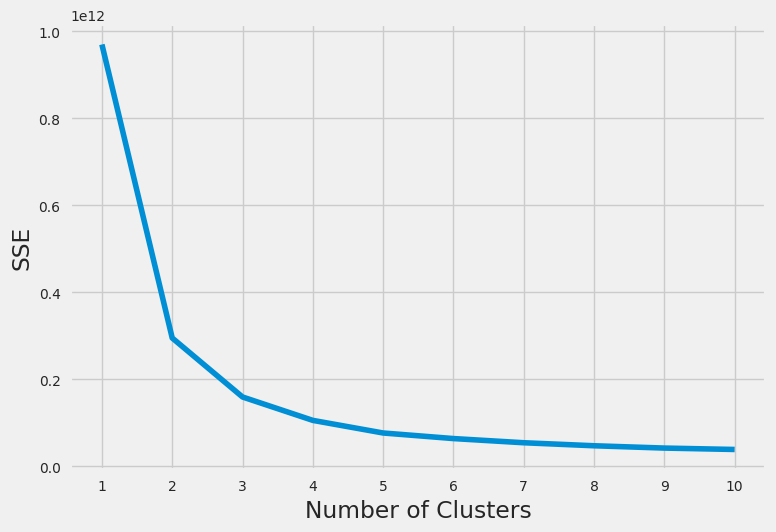

In [74]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse2)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [75]:
kl = KneeLocator(range(1, 11), sse2, curve="convex", direction="decreasing")

kl.elbow

3

In [76]:
 # A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_enc)
    score2 = silhouette_score(df_enc, kmeans.labels_)
    silhouette_coefficients.append(score2)

/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

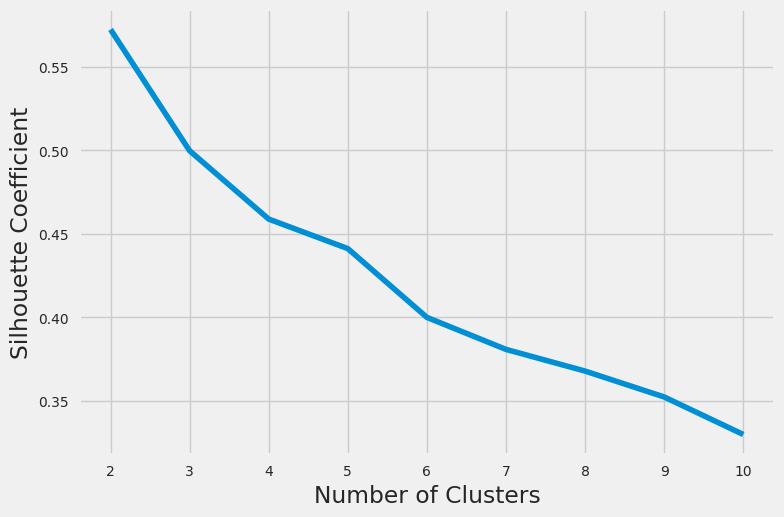

In [77]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [135]:
kmeans2 = KMeans(n_clusters = 5, max_iter = 1000)
labels2 = kmeans2.fit_predict(df_enc)
df_enc['cluster'] = labels2


/home/alicia/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



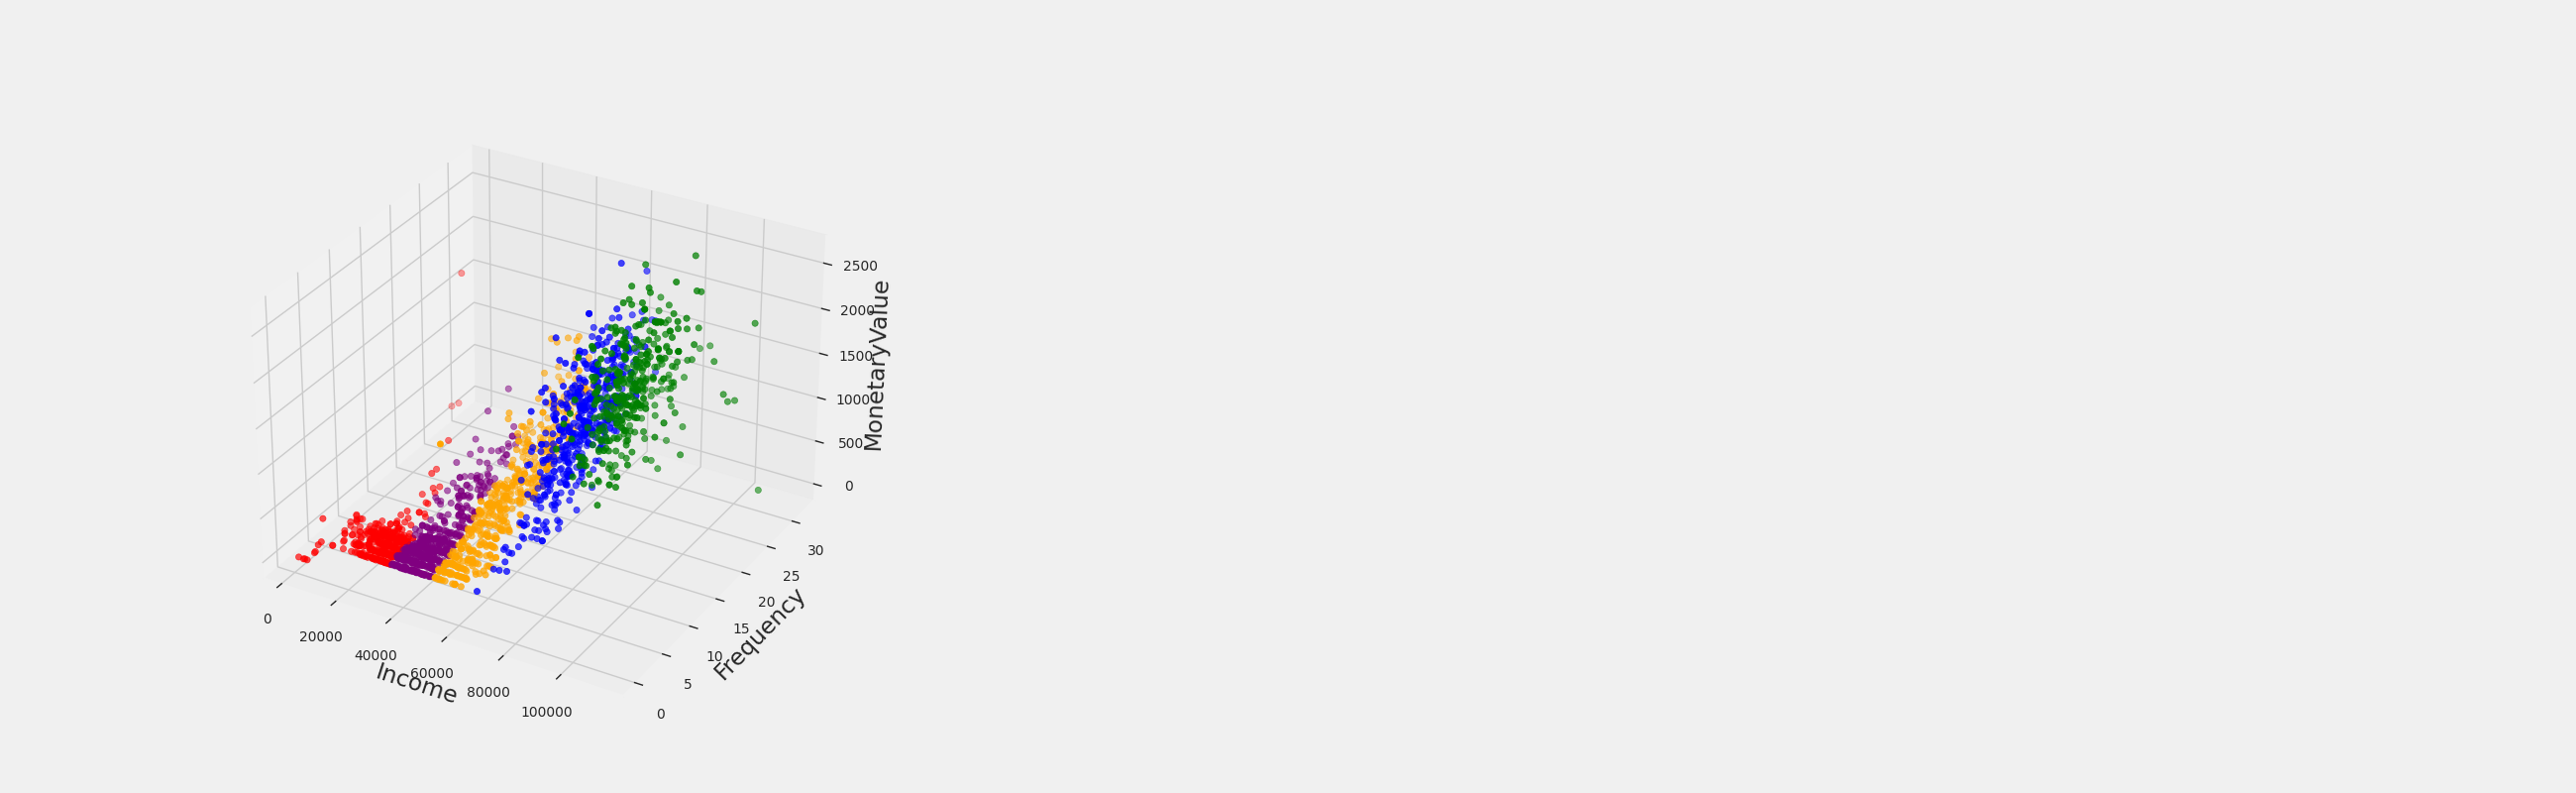

In [149]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
colors = ['blue', 'red', 'green','purple','orange']
df_enc2 = df_enc.copy()
df_enc2['c'] = df_enc2.cluster.map({0:colors[0], 1:colors[1], 2:colors[2] ,3:colors[3], 4:colors[4]})
fig = plt.figure(figsize=(26,8))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(df_enc2['Income'], df_enc2['Frequency'], df_enc2['MonetaryValue'], c=df_enc2.c)

ax.set_xlabel('Income')
ax.set_ylabel('Frequency')
ax.set_zlabel('MonetaryValue')
plt.show()


In [93]:
score2 = silhouette_score(df_enc, kmeans2.labels_)
score2

0.45881675718595866

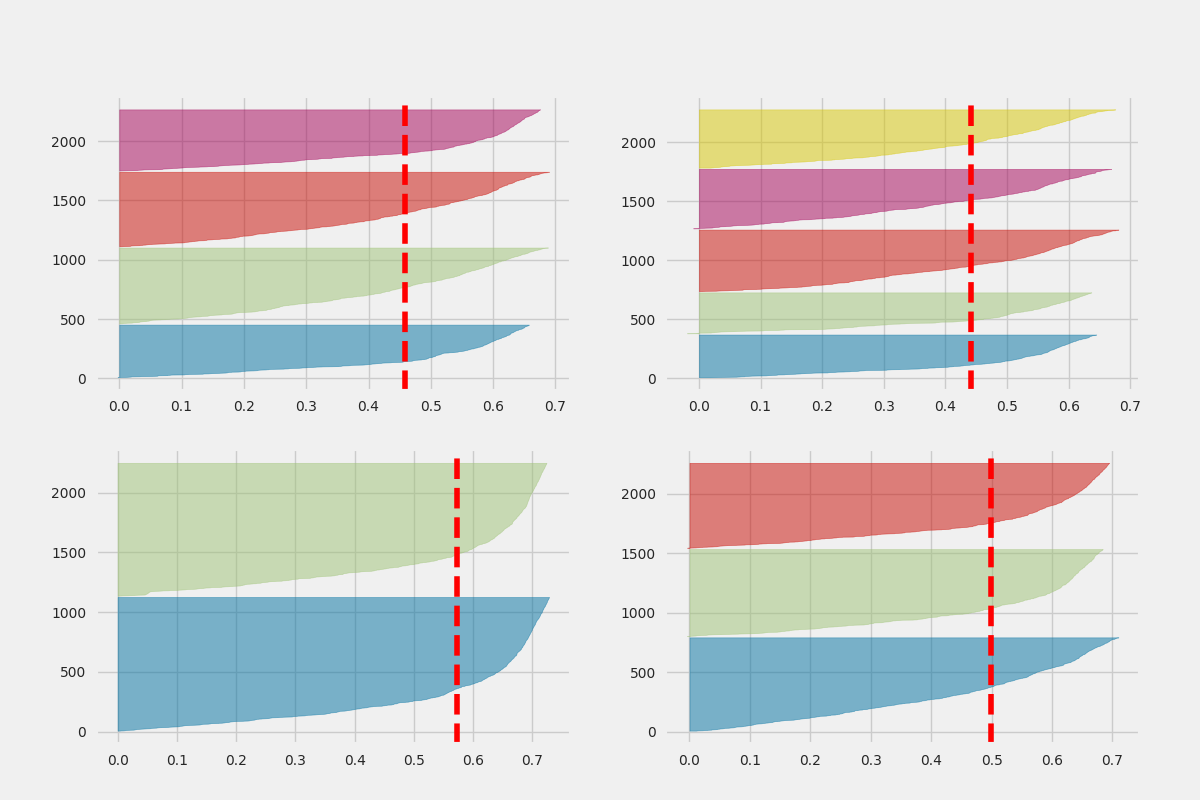

In [114]:
from yellowbrick.cluster import SilhouetteVisualizer
 
fig, ax = plt.subplots(2, 2, figsize=(12,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-2][mod])
    visualizer.fit(df_enc) 

## Lien entre le RFM et le clustering

In [136]:
df_rfm= pd.read_pickle("df_rfm.pkl")
df_rfm 

ID  Year_Birth   Education Marital_Status   Income Kidhome Teenhome  \
0      5524        1957  Graduation         Single  58138.0       0        0   
1      2174        1954  Graduation         Single  46344.0       1        1   
2      4141        1965  Graduation       Together  71613.0       0        0   
3      6182        1984  Graduation       Together  26646.0       1        0   
4      5324        1981         PhD        Married  58293.0       1        0   
...     ...         ...         ...            ...      ...     ...      ...   
2235  10870        1967  Graduation        Married  61223.0       0        1   
2236   4001        1946         PhD       Together  64014.0       2        1   
2237   7270        1981  Graduation       Divorced  56981.0       0        0   
2238   8235        1956      Master       Together  69245.0       0        1   
2239   9405        1954         PhD        Married  52869.0       1        1   

     Dt_Customer  Recency  MntWines  ...  AcceptedCmp4  AcceptedCmp5  \
0     04-09-2012       58       635  ...             0             0   
1     08-03-2014       38        11  ...             0             0   
2     21-08-2013       26       426  ...             0             0   
3     10-02-2014       26        11  ...             0             0   
4     19-01-2014       94       173  ...             0             0   
...          ...      ...       ...  ...           ...           ...   
2235  13-06-2013       46       709  ...             0             0   
2236  10-06-2014       56       406  ...             0             0   
2237  25-01-2014       91       908  ...             1             0   
2238  24-01-2014        8       428  ...             0             0   
2239  15-10-2012       40        84  ...             0             0   

      AcceptedCmp1  AcceptedCmp2  Complain  Response  Age     M   F  \
0                0             0         0         1   66  1789  22   
1                0             0         0         0   69    29   4   
2                0             0         0         0   58   887  20   
3                0             0         0         0   39    63   6   
4                0             0         0         0   42   468  14   
...            ...           ...       ...       ...  ...   ...  ..   
2235             0             0         0         0   56  1383  16   
2236             1             0         0         0   77   444  15   
2237             0             0         0         0   42  1273  18   
2238             0             0         0         0   67   923  21   
2239             0             0         0         1   69   174   8   

               RFM_Level  
0              Champions  
1          Low Potential  
2              Potential  
3          New Customers  
4          Low Potential  
...                  ...  
2235           Potential  
2236  Require activation  
2237  Require activation  
2238           Champions  
2239  Require activation  

[2240 rows x 31 columns]

In [137]:
df_enc

Recency  Frequency  MonetaryValue     ID  Age   Income Kidhome Teenhome  \
0          58         22           1789   5524   66  58138.0       0        0   
1          38          4             29   2174   69  46344.0       1        1   
2          26         20            887   4141   58  71613.0       0        0   
3          26          6             63   6182   39  26646.0       1        0   
4          94         14            468   5324   42  58293.0       1        0   
...       ...        ...            ...    ...  ...      ...     ...      ...   
2232       46         16           1383  10870   56  61223.0       0        1   
2233       56         15            444   4001   77  64014.0       2        1   
2234       91         18           1273   7270   42  56981.0       0        0   
2235        8         21            923   8235   67  69245.0       0        1   
2236       40          8            174   9405   69  52869.0       1        1   

      Year  Education_2n Cycle  Education_Basic  Education_Graduation  \
0     2012                 0.0              0.0                   1.0   
1     2014                 0.0              0.0                   1.0   
2     2013                 0.0              0.0                   1.0   
3     2014                 0.0              0.0                   1.0   
4     2014                 0.0              0.0                   0.0   
...    ...                 ...              ...                   ...   
2232  2013                 0.0              0.0                   1.0   
2233  2014                 0.0              0.0                   0.0   
2234  2014                 0.0              0.0                   1.0   
2235  2014                 0.0              0.0                   0.0   
2236  2012                 0.0              0.0                   0.0   

      Education_Master  Education_PhD  Marital_Status_Divorced  \
0                  0.0            0.0                      0.0   
1                  0.0            0.0                      0.0   
2                  0.0            0.0                      0.0   
3                  0.0            0.0                      0.0   
4                  0.0            1.0                      0.0   
...                ...            ...                      ...   
2232               0.0            0.0                      0.0   
2233               0.0            1.0                      0.0   
2234               0.0            0.0                      1.0   
2235               1.0            0.0                      0.0   
2236               0.0            1.0                      0.0   

      Marital_Status_Married  Marital_Status_Single  Marital_Status_Together  \
0                        0.0                    1.0                      0.0   
1                        0.0                    1.0                      0.0   
2                        0.0                    0.0                      1.0   
3                        0.0                    0.0                      1.0   
4                        1.0                    0.0                      0.0   
...                      ...                    ...                      ...   
2232                     1.0                    0.0                      0.0   
2233                     0.0                    0.0                      1.0   
2234                     0.0                    0.0                      0.0   
2235                     0.0                    0.0                      1.0   
2236                     1.0                    0.0                      0.0   

      Marital_Status_Widow  cluster  
0                      0.0        4  
1                      0.0        4  
2                      0.0        0  
3                      0.0        1  
4                      0.0        4  
...                    ...      ...  
2232                   0.0        0  
2233                   0.0        0  
2234                   0.0        4  
2235                  

In [138]:
table = pd.merge(df_enc, df_rfm, on='ID', how='inner',indicator=True)
table

Recency_x  Frequency  MonetaryValue     ID  Age_x  Income_x Kidhome_x  \
0            58         22           1789   5524     66   58138.0         0   
1            38          4             29   2174     69   46344.0         1   
2            26         20            887   4141     58   71613.0         0   
3            26          6             63   6182     39   26646.0         1   
4            94         14            468   5324     42   58293.0         1   
...         ...        ...            ...    ...    ...       ...       ...   
2224         46         16           1383  10870     56   61223.0         0   
2225         56         15            444   4001     77   64014.0         2   
2226         91         18           1273   7270     42   56981.0         0   
2227          8         21            923   8235     67   69245.0         0   
2228         40          8            174   9405     69   52869.0         1   

     Teenhome_x  Year  Education_2n Cycle  ...  AcceptedCmp5  AcceptedCmp1  \
0             0  2012                 0.0  ...             0             0   
1             1  2014                 0.0  ...             0             0   
2             0  2013                 0.0  ...             0             0   
3             0  2014                 0.0  ...             0             0   
4             0  2014                 0.0  ...             0             0   
...         ...   ...                 ...  ...           ...           ...   
2224          1  2013                 0.0  ...             0             0   
2225          1  2014                 0.0  ...             0             1   
2226          0  2014                 0.0  ...             0             0   
2227          1  2014                 0.0  ...             0             0   
2228          1  2012                 0.0  ...             0             0   

      AcceptedCmp2  Complain  Response  Age_y     M   F           RFM_Level  \
0                0         0         1     66  1789  22           Champions   
1                0         0         0     69    29   4       Low Potential   
2                0         0         0     58   887  20           Potential   
3                0         0         0     39    63   6       New Customers   
4                0         0         0     42   468  14       Low Potential   
...            ...       ...       ...    ...   ...  ..                 ...   
2224             0         0         0     56  1383  16           Potential   
2225             0         0         0     77   444  15  Require activation   
2226             0         0         0     42  1273  18  Require activation   
2227             0         0         0     67   923  21           Champions   
2228             0         0         1     69   174   8  Require activation   

      _merge  
0       both  
1       both  
2       both  
3       both  
4       both  
...      ...  
2224    both  
2225    both  
2226    both  
2227    both  
2228    both  

[2229 rows x 51 columns]

In [139]:
table.columns

Index(['Recency_x', 'Frequency', 'MonetaryValue', 'ID', 'Age_x', 'Income_x',
       'Kidhome_x', 'Teenhome_x', 'Year', 'Education_2n Cycle',
       'Education_Basic', 'Education_Graduation', 'Education_Master',
       'Education_PhD', 'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'cluster', 'Year_Birth', 'Education',
       'Marital_Status', 'Income_y', 'Kidhome_y', 'Teenhome_y', 'Dt_Customer',
       'Recency_y', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Age_y', 'M', 'F', 'RFM_Level', '_merge'],
      dtype='object')

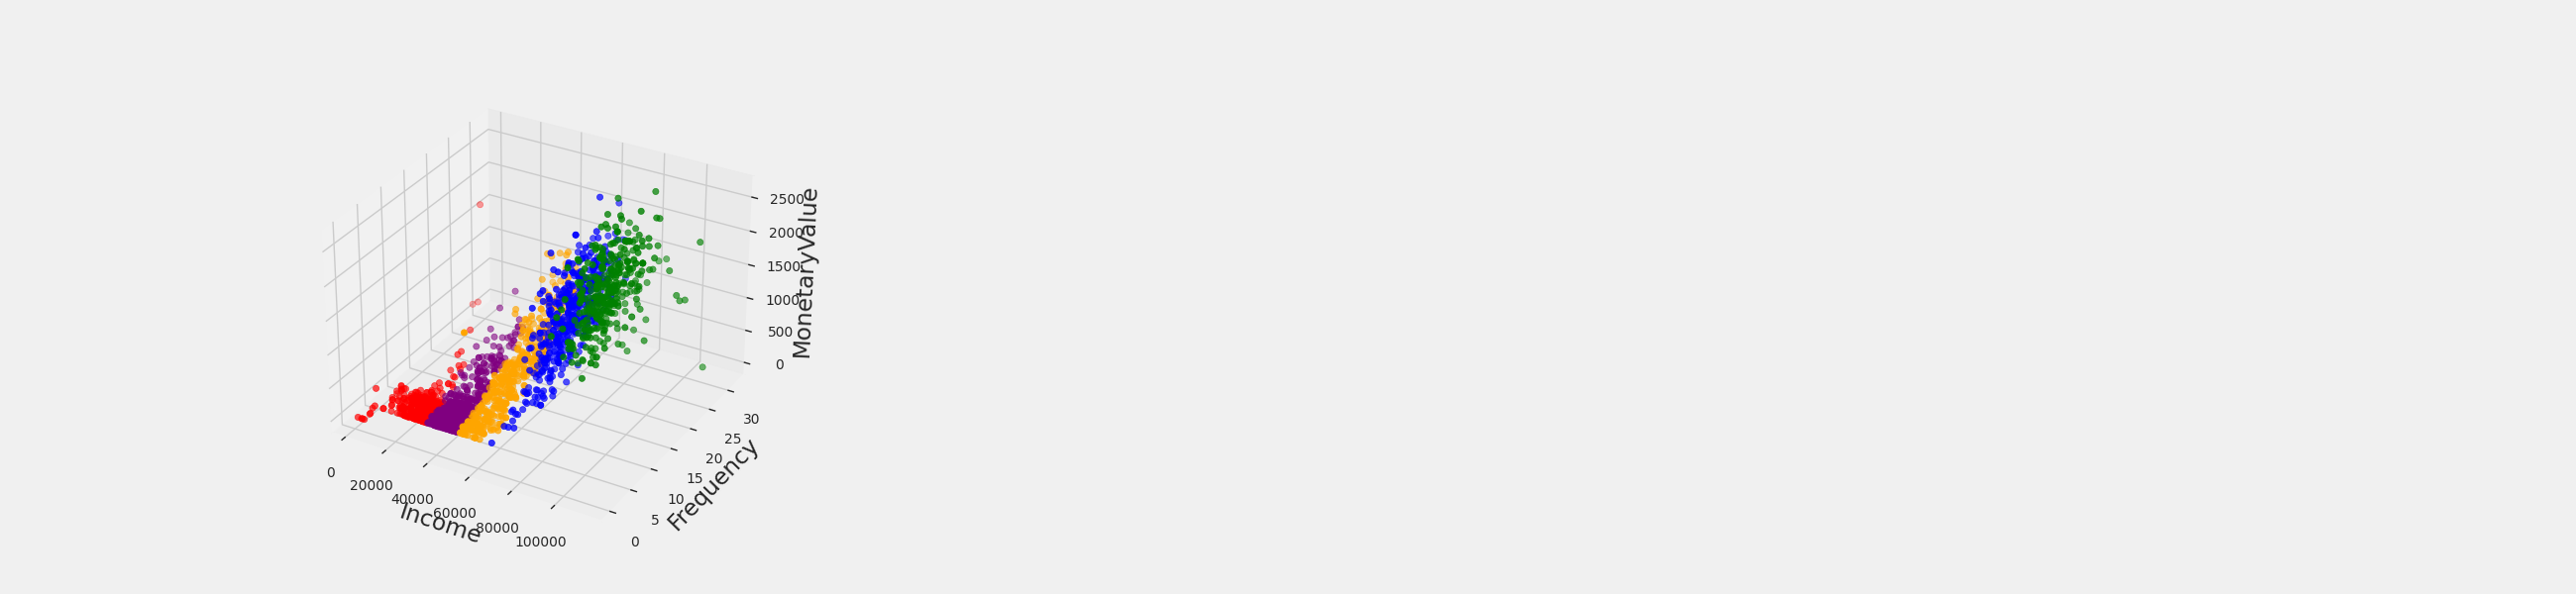

In [140]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
colors = ['blue', 'red', 'green','purple','orange']

table['c'] = table.cluster.map({0:colors[0], 1:colors[1], 2:colors[2] ,3:colors[3], 4:colors[4]})
fig = plt.figure(figsize=(26,6))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(table['Income_x'], table['Frequency'], table['MonetaryValue'], c=table.c)

ax.set_xlabel('Income')
ax.set_ylabel('Frequency')
ax.set_zlabel('MonetaryValue')
plt.show()

In [145]:
champ = table.loc[table['RFM_Level']== 'Champions']
champ['c'].value_counts()

green     194
blue      193
orange     38
red         1
purple      1
Name: c, dtype: int64

In [146]:
pot = table.loc[table['RFM_Level']== 'Potential']
pot['c'].value_counts()

blue      146
orange    128
green      78
purple     60
red         4
Name: c, dtype: int64

In [147]:
new = table.loc[table['RFM_Level']== 'New Customers']
new['c'].value_counts()

purple    133
red       102
orange     48
blue        1
Name: c, dtype: int64

In [148]:
low = table.loc[table['RFM_Level']== 'Low Potential']
low['c'].value_counts()

purple    269
red       228
orange    157
blue       38
green       4
Name: c, dtype: int64

In [105]:
req = table.loc[table['RFM_Level']== 'Require activation']
req['c'].value_counts()

green     179
blue      121
red        90
purple     16
Name: c, dtype: int64

# Conlusions